In [25]:
import pickle as pickle
import os
import pandas as pd
import torch
from functools import partial

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
from collections import defaultdict, Counter
from wordcloud import WordCloud, STOPWORDS
from konlpy.tag import Mecab
m = Mecab()
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore')

# from pororo import Pororo

In [2]:
def preprocessing_dataset(dataset):
    train_subject_entity = []
    train_object_entity = []
    train_subject_type = []
    train_object_type = []
    val_subject_entity = []
    val_object_entity = []
    val_subject_type = []
    val_object_type = []

    for train in train_examples['train']:
        train_subject_entity.append(train['subject_entity']['word'])
        train_object_entity.append(train['object_entity']['word'])
        train_subject_type.append(train['subject_entity']['type'])
        train_object_type.append(train['object_entity']['type'])
    
    for val in train_examples['valid']:
        val_subject_entity.append(val['subject_entity']['word'])
        val_object_entity.append(val['object_entity']['word'])
        val_subject_type.append(val['subject_entity']['type'])
        val_object_type.append(val['object_entity']['type'])
        
        
    train_dataset = pd.DataFrame({'id':dataset['train']['guid'], 'sentence':dataset['train']['sentence'],
                                  'subject_entity':train_subject_entity,'object_entity':train_object_entity,
                                  'subject_type':train_subject_type, 'object_type':train_object_type,'source':dataset['train']['source'], 
                                  'label':dataset['train']['label'], 'text': dataset['train']['text']})
    
    val_dataset = pd.DataFrame({'id':dataset['valid']['guid'], 'sentence':dataset['valid']['sentence'],
                                  'subject_entity':val_subject_entity,'object_entity':val_object_entity,
                                  'subject_type':val_subject_type, 'object_type':val_object_type,'source':dataset['valid']['source'], 
                                  'label':dataset['valid']['label'], 'text': dataset['valid']['text']})
    
    out_dataset = pd.concat([train_dataset, val_dataset])
    out_dataset['id'] = out_dataset['id'].map(int)
    return out_dataset.sort_values(['id']).reset_index(drop=True)

In [5]:
markers = dict(
    subject_start_marker="<subj>",
    subject_end_marker="</subj>",
    object_start_marker="<obj>",
    object_end_marker="</obj>",
)

In [6]:
from typing import Dict, Tuple, List, Any


# create_example
def _mark_entity_spans(examples,
                      subject_start_marker: str, subject_end_marker: str,
                      object_start_marker: str, object_end_marker: str):

    def _mark_entity_spans(
        text: str, 
        subject_range=Tuple[int, int], 
        object_range=Tuple[int, int]
    ) -> str:
        """ Adds entity markers to the text to identify the subject/object entities.
        Args:
            text: Original sentence
            subject_range: Pair of start and end indices of subject entity
            object_range: Pair of start and end indices of object entity
        Returns:
            A string of text with subject/object entity markers
        """
        if subject_range < object_range:
            segments = [
                text[: subject_range[0]],
                subject_start_marker,
                text[subject_range[0] : subject_range[1] + 1],
                subject_end_marker,
                text[subject_range[1] + 1 : object_range[0]],
                object_start_marker,
                text[object_range[0] : object_range[1] + 1],
                object_end_marker,
                text[object_range[1] + 1 :],
            ]
        elif subject_range > object_range:
            segments = [
                text[: object_range[0]],
                object_start_marker,
                text[object_range[0] : object_range[1] + 1],
                object_end_marker,
                text[object_range[1] + 1 : subject_range[0]],
                subject_start_marker,
                text[subject_range[0] : subject_range[1] + 1],
                subject_end_marker,
                text[subject_range[1] + 1 :],
            ]
        else:
            raise ValueError("Entity boundaries overlap.")

        marked_text = "".join(segments)

        return marked_text
    
    subject_entity = examples["subject_entity"]
    object_entity = examples["object_entity"]
    
    text = _mark_entity_spans(
        examples["sentence"],
        (subject_entity["start_idx"], subject_entity["end_idx"]),
        (object_entity["start_idx"], object_entity["end_idx"]),
    )
    return {"text": text}

In [7]:
mark_entity_spans = partial(_mark_entity_spans, **markers)

## Load Dataset

In [17]:
with open('../data/dict_label_to_num.pkl', 'rb') as f:
    dict_label_to_num = pickle.load(f)
with open('../data/dict_num_to_label.pkl', 'rb') as f:
    dict_num_to_label = pickle.load(f)

In [10]:
from datasets import load_dataset

data = load_dataset("jinmang2/load_klue_re", script_version="v1.0.1b")

Reusing dataset klue_re (/opt/ml/.cache/huggingface/datasets/klue_re/re/1.0.1/72db5b4f9111ca3106d23ecec67a53f750c70b70b32c5512f925baac3b39a0de)


  0%|          | 0/3 [00:00<?, ?it/s]

## Preprocessing Data

In [26]:
train_examples = data.map(mark_entity_spans)

Loading cached processed dataset at /opt/ml/.cache/huggingface/datasets/klue_re/re/1.0.1/72db5b4f9111ca3106d23ecec67a53f750c70b70b32c5512f925baac3b39a0de/cache-1b60102a6a3dc2ac.arrow
Loading cached processed dataset at /opt/ml/.cache/huggingface/datasets/klue_re/re/1.0.1/72db5b4f9111ca3106d23ecec67a53f750c70b70b32c5512f925baac3b39a0de/cache-0f19d2ecbd908cf9.arrow
Loading cached processed dataset at /opt/ml/.cache/huggingface/datasets/klue_re/re/1.0.1/72db5b4f9111ca3106d23ecec67a53f750c70b70b32c5512f925baac3b39a0de/cache-6ca47e8cb16bae22.arrow


In [27]:
pd_dataset = preprocessing_dataset(train_examples)
pd_dataset

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,비틀즈,조지 해리슨,ORG,PER,wikipedia,0,〈Something〉는 <obj>조지 해리슨</obj>이 쓰고 <subj>비틀즈</...
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,민주평화당,대안신당,ORG,ORG,wikitree,0,호남이 기반인 바른미래당·<obj>대안신당</obj>·<subj>민주평화당</sub...
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,광주FC,한국프로축구연맹,ORG,ORG,wikitree,20,K리그2에서 성적 1위를 달리고 있는 <subj>광주FC</subj>는 지난 26일...
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,아성다이소,박정부,ORG,PER,wikitree,1,균일가 생활용품점 (주)<subj>아성다이소</subj>(대표 <obj>박정부</o...
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,요미우리 자이언츠,1967,ORG,DAT,wikipedia,0,<obj>1967</obj>년 프로 야구 드래프트 1순위로 <subj>요미우리 자이...
...,...,...,...,...,...,...,...,...,...
32465,32465,한국당은 7일 오전 9시부터 오후 5시까지 진행된 원내대표 및 정책위의장 후보자 등...,유기준,부산 서구·동구,PER,LOC,wikitree,6,한국당은 7일 오전 9시부터 오후 5시까지 진행된 원내대표 및 정책위의장 후보자 등...
32466,32466,"법포는 다시 최시형, 서병학, 손병희 직계인 북접과 다시 서장옥, 전봉준, 김개남을...",최시형,손병희,PER,PER,wikipedia,14,"법포는 다시 <subj>최시형</subj>, 서병학, <obj>손병희</obj> 직..."
32467,32467,완도군(군수 신우철)이 국토교통부에서 실시한 '2019 교통문화지수 실태조사'에서 ...,완도군,신우철,ORG,PER,wikitree,1,<subj>완도군</subj>(군수 <obj>신우철</obj>)이 국토교통부에서 실...
32468,32468,"중앙일보, JTBC 회장을 지낸 이후 중앙홀딩스 회장, 재단법인 한반도평화만들기 이...",JTBC,중앙홀딩스,ORG,ORG,wikipedia,0,"중앙일보, <subj>JTBC</subj> 회장을 지낸 이후 <obj>중앙홀딩스</..."


In [28]:
display(pd_dataset.subject_type.value_counts())
display(pd_dataset.object_type.value_counts())

PER    16786
ORG    15684
Name: subject_type, dtype: int64

PER    9788
ORG    9346
POH    5113
DAT    4249
LOC    3561
NOH     413
Name: object_type, dtype: int64

In [29]:
pd_dataset.source.unique()

array(['wikipedia', 'wikitree', 'policy_briefing'], dtype=object)

In [30]:
dict_num_to_label.values()

dict_values(['no_relation', 'org:top_members/employees', 'org:members', 'org:product', 'per:title', 'org:alternate_names', 'per:employee_of', 'org:place_of_headquarters', 'per:product', 'org:number_of_employees/members', 'per:children', 'per:place_of_residence', 'per:alternate_names', 'per:other_family', 'per:colleagues', 'per:origin', 'per:siblings', 'per:spouse', 'org:founded', 'org:political/religious_affiliation', 'org:member_of', 'per:parents', 'org:dissolved', 'per:schools_attended', 'per:date_of_death', 'per:date_of_birth', 'per:place_of_birth', 'per:place_of_death', 'org:founded_by', 'per:religion'])

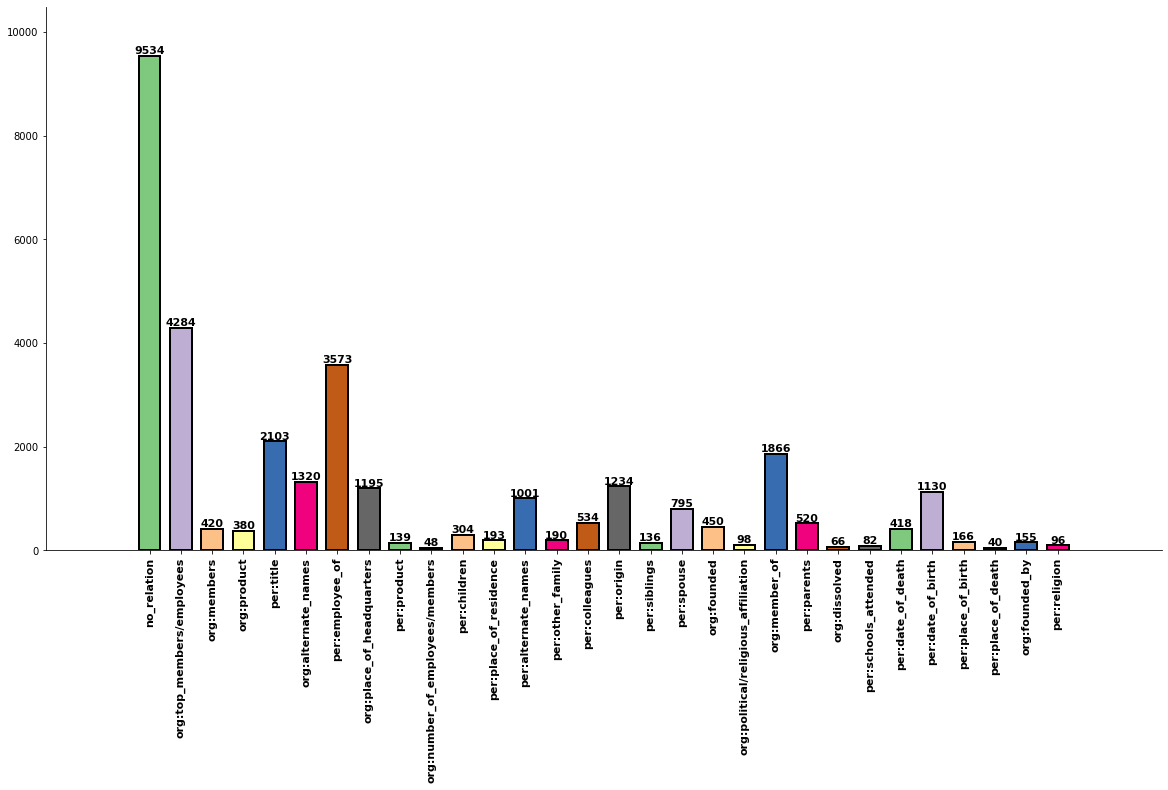

In [31]:
palette = sns.color_palette("Accent")
group_cnt = pd_dataset['label'].value_counts().sort_index()

fig, ax = plt.subplots(1, 1, figsize=(20, 10))


ax.bar(dict_num_to_label.values(), group_cnt,
       width=0.7,
       edgecolor='black',
       linewidth=2,
       color=palette,
       zorder=10
      )
ax.set_xticklabels(dict_num_to_label.values(), fontsize=11, fontweight='semibold', rotation=90)
ax.margins(0.1, 0.1)

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)


for idx, value in zip(group_cnt.index, group_cnt):
    ax.text(idx, value+5, s=value,
                 ha='center', 
                 fontweight='semibold',
                 fontsize=11,
                 va='bottom'
                )
        
plt.show()

## UNK 처리 파악

In [32]:
from transformers import AutoModel, AutoTokenizer, BertTokenizer

In [33]:
MODEL_NAME = "klue/roberta-large"

In [34]:
model = AutoModel.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it f

In [35]:
unknown = set()

In [36]:
for i, rows in pd_dataset.iterrows():
    e1, e2 = rows['subject_entity'], rows['object_entity']
    
    if tokenizer.tokenize(e1)[0] == "[UNK]":
        unknown.add(e1)
    if tokenizer.tokenize(e2)[0] == "[UNK]":
        unknown.add(e2)

In [37]:
unknown

{'Håvard Nordtveit',
 'Jürgen Kohler',
 'MŠK 질리나',
 'RÚV',
 'Saša Drakulić',
 'Víctor Ruiz Torre',
 'française',
 'ÖBB',
 'Śākyamuni',
 'Διόνυσος',
 'Μίκης Θεοδωράκης',
 'あゆみ',
 'いけだ',
 'さあや',
 'たかし',
 'たなか',
 'まどか',
 'みなみ',
 'みゆき',
 'ルールー・アムール',
 '伊達氏',
 '佐々木莉佳子',
 '唐田えりか',
 '少弐氏',
 '尹鍾信',
 '崔彰權',
 '徳川氏',
 '曺世鉉',
 '李娥珠',
 '李承萬',
 '李鍾熙',
 '栃木SC',
 '梁啓超',
 '森 喜朗',
 '洪景來',
 '浙江广播电视集团',
 '清和政策研究会',
 '玉置浩二',
 '監理會',
 '真田氏',
 '竹内美宥',
 '織田信長',
 '織田氏',
 '聯合國',
 '蔚山放送',
 '蔡基中',
 '藤原氏',
 '豊臣氏',
 '郭在驥',
 '釋迦牟尼',
 '鈴木貫太郎',
 '香港工會聯合會',
 '香西 香',
 '겐츨레르비를리이',
 '껀브엉 운동',
 '넋업샨',
 '넵투누스',
 '다롄 스더',
 '다롄 이팡',
 '뎀나 바잘리아',
 '두샨 바예비치',
 '똔텃투옛',
 '량훙즈',
 '로퀜스',
 '리셴녠',
 '리셴룽',
 '리옌훙',
 '리콴유',
 '린뱌오',
 '막찐쭝',
 '맬 영',
 '멍훙웨이',
 '메이헴',
 '묀헨글라트바흐',
 '믈라덴 크르스타이치',
 '방얏 반타탄',
 '뱌체슬라프 몰로토프',
 '베렝가리오 1세',
 '벵갈루루 FC',
 '브뢴뷔 IF',
 '비욘세',
 '서벵골주',
 '세묜 티모셴코',
 '숀 라이트필립스',
 '숀 멘데스',
 '숀 탠',
 '숀 폴 록하트',
 '숲튽훈',
 '스뱌토폴크 1세',
 '스뱌토폴크 2세',
 '쑹타오',
 '쓰촨 관청',
 '쓰촨 취안싱',
 '아녜스',
 '아녜스 드 부르고뉴',
 '아뎀 랴이치',
 '아르툠 미코얀',
 '아믈리브 막

In [ ]:
# wt = Pororo(task="word_translation", lang="ja", tgt="ko")
# wt("apple")

## hierarchical 파악

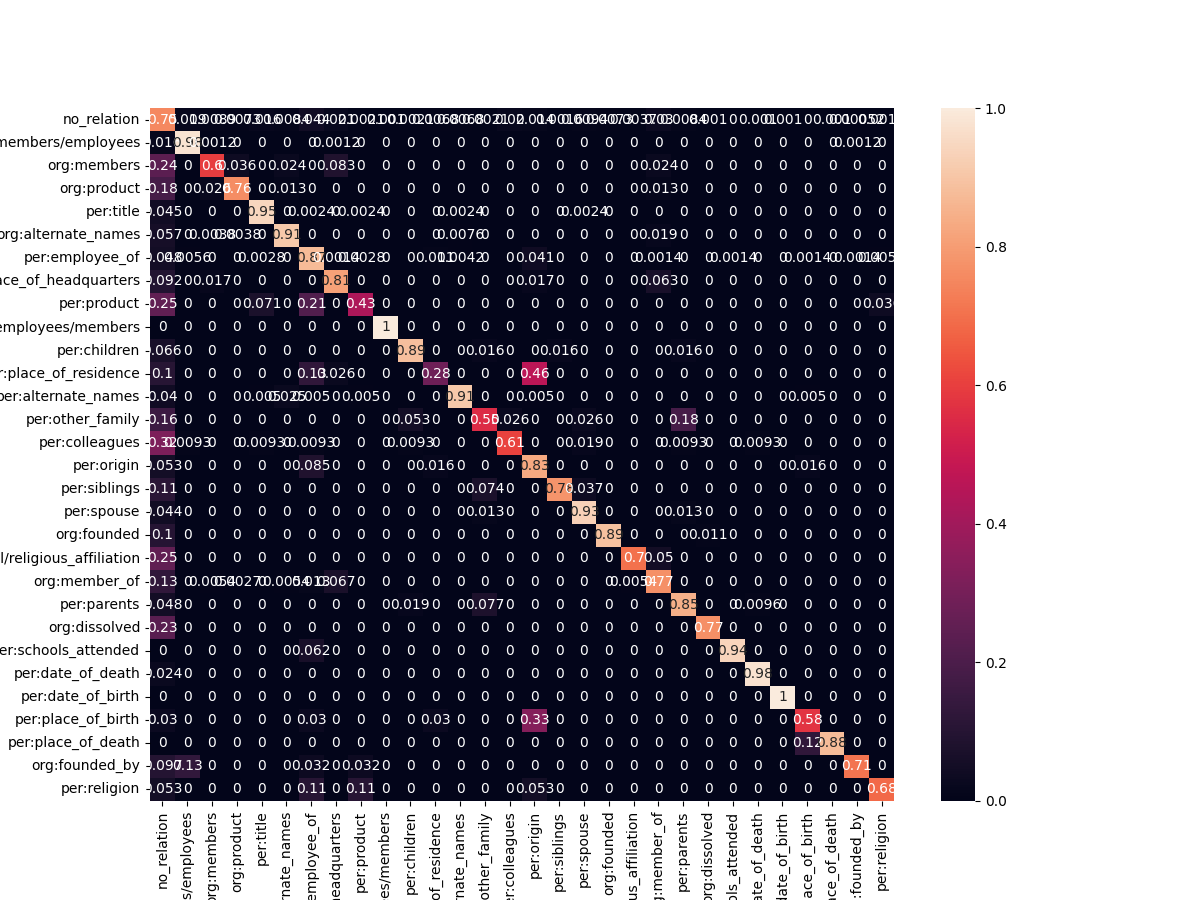

출처: 하람님의 roberta_to_compare 실험

### org:top_members/employees
The representative(s) or members of the specified organization

지정된 조직(subject ORG)의 대표자 또는 구성원(object PER)

In [203]:
pd_dataset.query('label == 1').object_type.value_counts()

PER    4196
POH      52
ORG      22
LOC      13
NOH       1
Name: object_type, dtype: int64

In [204]:
pd_dataset.query('label == 1 & subject_type != "ORG"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
14958,14958,그룹 2AM 출신 정진운 씨와 나인뮤지스 출신 경리가 열애를 인정한 가운데 두 사람...,2AM,정진운,PER,PER,wikitree,1,그룹 <subj>2AM</subj> 출신 <obj>정진운</obj> 씨와 나인뮤지스...


In [42]:
pd_dataset.query('label == 1 & object_type != "PER" & object_type != "POH"')
# 30879 index의 경우 object_type은 제대로 되어있고 label이 잘못된 케이스

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
2739,2739,도쿠가와 씨는 1800년대 중반에 에도 막부가 문을 닫을 때까지 미토를 직접 통치하였다.,에도 막부,도쿠가와,ORG,ORG,wikipedia,1,<obj>도쿠가와</obj> 씨는 1800년대 중반에 <subj>에도 막부</sub...
4197,4197,재단법인 오뚜기함태호재단은 6월 27일 인천 송도컨벤시아에서 ‘제20회 오뚜기 함태...,오뚜기,함태호,ORG,ORG,wikitree,1,재단법인 <subj>오뚜기</subj><obj>함태호</obj>재단은 6월 27일 ...
4428,4428,쾰른의 브루노(1130년 - 1101년 10월 6일)은 로마 가톨릭교회 성인이자 수...,로마 가톨릭교회,쾰른의 브루노,ORG,LOC,wikipedia,1,<obj>쾰른의 브루노</obj>(1130년 - 1101년 10월 6일)은 <sub...
5053,5053,"소울 컴퍼니의 Kebee와 함께 이룬 프로젝트 앨범, ""Eluphant Bakery...",소울 컴퍼니,Kebee,ORG,ORG,wikipedia,1,<subj>소울 컴퍼니</subj>의 <obj>Kebee</obj>와 함께 이룬 프...
5955,5955,횡성 고씨 고구려 왕실종친회는 2015년 대한민국 통계청 인구조사에서 약 1만명 조...,고구려 왕실종친회,횡성 고씨,ORG,LOC,wikipedia,1,<obj>횡성 고씨</obj> <subj>고구려 왕실종친회</subj>는 2015년...
8297,8297,1945년 9월 호찌민은 하노이를 수도로 하여 베트남 민주 공화국(북베트남)의 독립...,베트남,호찌민,ORG,LOC,wikipedia,1,1945년 9월 <obj>호찌민</obj>은 하노이를 수도로 하여 <subj>베트남...
9233,9233,기원전 27년에 원로원으로부터 아우구스투스의 칭호를 받으며 임페라토르로 등극한 옥타...,로마 제국,원로원,ORG,ORG,wikipedia,1,기원전 27년에 <obj>원로원</obj>으로부터 아우구스투스의 칭호를 받으며 임페...
10601,10601,재단법인 오뚜기함태호재단은 10월 24일 제주 국제컨벤션센터에서 ‘제21회 오뚜기 ...,오뚜기,함태호,ORG,ORG,wikitree,1,재단법인 <subj>오뚜기</subj><obj>함태호</obj>재단은 10월 24일...
10854,10854,"이 제의는 소위 대박을 내었고, 리버풀 FC의 악명높은 안필드 스피온 콥 스탠드의 ...",리버풀 FC,안필드,ORG,LOC,wikipedia,1,"이 제의는 소위 대박을 내었고, <subj>리버풀 FC</subj>의 악명높은 <o..."
11002,11002,한국해양대학교 제8대 도덕희 총장 취임식이 12월 2일 오후 2시 대학 대강당에서 ...,한국해양대학교,도덕희,ORG,NOH,wikitree,1,<subj>한국해양대학교</subj> 제8대 <obj>도덕희</obj> 총장 취임식...


### org:members
Organizations which belong to the specified organization

지정된 조직(subject ORG)에 속한 조직(object ORG)

In [202]:
pd_dataset.query('label == 2').object_type.value_counts()

ORG    285
LOC     97
POH     32
PER      3
NOH      2
DAT      1
Name: object_type, dtype: int64

In [205]:
pd_dataset.query('label == 2 & subject_type != "ORG"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
3118,3118,"이후 태연, 써니, 효연, 유리, 윤아로 소녀시대의 두 번째 유닛 그룹 소녀시대-O...",소녀시대,소녀시대-Oh!GG,PER,PER,wikipedia,2,"이후 태연, 써니, 효연, 유리, 윤아로 <subj>소녀시대</subj>의 두 번째..."


In [43]:
pd_dataset.query('label == 2 & object_type != "ORG" & object_type != "POH"')
# LOC 말고도 다른 object도 있지만 LOC를 어떻게 처리할지 고민

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
13,13,뉴질랜드 1차산업부 생물보안 대변인 캐서린 더시 박사는 과일파리를 잡기 위해 오클랜...,뉴질랜드,오클랜드,ORG,LOC,wikitree,2,<subj>뉴질랜드</subj> 1차산업부 생물보안 대변인 캐서린 더시 박사는 과일...
135,135,"한편, 러시아의 경우에도 러시아 측의 조치로 인해 올 3월부터 인천-모스크바 간 정...",러시아,모스크바,ORG,LOC,policy_briefing,2,"한편, 러시아의 경우에도 <subj>러시아</subj> 측의 조치로 인해 올 3월부..."
364,364,1999년에는 토론토에 본사를 둔 CPR계 캐나다 태평양 호텔 & 리조트 사(CPH...,캐나다,토론토,ORG,LOC,wikipedia,2,1999년에는 <obj>토론토</obj>에 본사를 둔 CPR계 <subj>캐나다</...
588,588,"칼마르 동맹(Kalmarunionen, 1397년 ~ 1523년) 또는 스칸디나비아...",칼마르 동맹,덴마크,ORG,LOC,wikipedia,2,"<subj>칼마르 동맹</subj>(Kalmarunionen, 1397년 ~ 152..."
806,806,"세르게이 니콜라예비치 이그나셰비치(1979년 7월 14일, 러시아 SFSR 모스크바...",러시아,모스크바,ORG,LOC,wikipedia,2,"세르게이 니콜라예비치 이그나셰비치(1979년 7월 14일, 러시아 SFSR <obj..."
...,...,...,...,...,...,...,...,...,...
31348,31348,"그는 헝가리 1부리그, 부다페스트를 연고로 하는 셰펠 SC에서 준수한 활약을 하였다.",헝가리,부다페스트,ORG,LOC,wikipedia,2,"그는 <subj>헝가리</subj> 1부리그, <obj>부다페스트</obj>를 연고..."
31661,31661,그러나 웨일스가 잉글랜드 왕국에 합병 이후에도 웨일스 법은 계속 유지되었다.,잉글랜드 왕국,웨일스,ORG,LOC,wikipedia,2,그러나 <obj>웨일스</obj>가 <subj>잉글랜드 왕국</subj>에 합병 이...
31865,31865,"텍사스 대학교 오스틴 재학 중, 캠퍼스에서 10명의 가장 아름다운 미인들 10명 중...",텍사스,오스틴,ORG,LOC,wikipedia,2,"<subj>텍사스</subj> 대학교 <obj>오스틴</obj> 재학 중, 캠퍼스에..."
32409,32409,중세 세르비아 공국의 수도였던 스타리라스(Stari Ras)가 사라진 뒤에 설립된 ...,중세 세르비아 공국,스타리라스,ORG,LOC,wikipedia,2,<subj>중세 세르비아 공국</subj>의 수도였던 <obj>스타리라스</obj>...


In [45]:
pd_dataset.query('label == 2 & object_type != "ORG" & object_type != "POH" & object_type != "LOC"')
# LOC 말고도 다른 object도 있지만 LOC를 어떻게 처리할지 고민

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
3118,3118,"이후 태연, 써니, 효연, 유리, 윤아로 소녀시대의 두 번째 유닛 그룹 소녀시대-O...",소녀시대,소녀시대-Oh!GG,PER,PER,wikipedia,2,"이후 태연, 써니, 효연, 유리, 윤아로 <subj>소녀시대</subj>의 두 번째..."
18065,18065,2001년 3월 28일부터 2003년 12월 24일까지 바실리예프는 러시아 내무부 ...,러시아,모스크바,ORG,DAT,wikipedia,2,2001년 3월 28일부터 2003년 12월 24일까지 바실리예프는 <subj>러시...
19704,19704,1990년에는 올랭피크 드 마르세유로 이적했고 1990-91 시즌에서는 올랭피크 드...,올랭피크 드 마르세유,리그 1,ORG,NOH,wikipedia,2,1990년에는 올랭피크 드 마르세유로 이적했고 1990-91 시즌에서는 <subj>...
23361,23361,"펠릭스클레르 리델(Félix-Clair Ridel, 1830년 7월 7일 ~ 188...",천주교 조선교구,대교구,ORG,NOH,wikipedia,2,"펠릭스클레르 리델(Félix-Clair Ridel, 1830년 7월 7일 ~ 188..."
29766,29766,당시 비틀즈의 판권을 가지고 있는 애플 레코드가 음악에 대한 모든 상표권을 가지고 ...,애플 레코드,비틀즈,ORG,PER,wikipedia,2,당시 <obj>비틀즈</obj>의 판권을 가지고 있는 <subj>애플 레코드</su...
30202,30202,비록 ICOMOS의 권고 시점에서 기준(4)의 적용은 부정되었고 세계문화유산 위원회...,문화유산,히라이즈미,ORG,PER,wikipedia,2,비록 ICOMOS의 권고 시점에서 기준(4)의 적용은 부정되었고 세계<subj>문화...


### org:product
Products or merchandise produced by the specified organization

지정된 조직(subject ORG)에서 생산하는 제품 또는 상품(object ?)

In [201]:
pd_dataset.query('label == 3').object_type.value_counts()

POH    304
ORG     48
LOC     24
PER      3
NOH      1
Name: object_type, dtype: int64

In [206]:
pd_dataset.query('label == 3 & subject_type != "ORG"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text


In [46]:
pd_dataset.query('label == 3 & object_type != "POH"')
# 이건 대체로 POH가 되어야 하지 않을까

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
210,210,주거 브랜드인 삼부르네상스를 도시에 두고 있고 삼부토건사인 조정구에 의해 설립하였다.,삼부토건,삼부르네상스,ORG,ORG,wikipedia,3,주거 브랜드인 <obj>삼부르네상스</obj>를 도시에 두고 있고 <subj>삼부토...
257,257,그는 “기업 측의 보수적인 가이던스를 참고해보면 올해 매출액 1조원은 최저 준”이라...,삼성전자,LSI,ORG,ORG,wikitree,3,그는 “기업 측의 보수적인 가이던스를 참고해보면 올해 매출액 1조원은 최저 준”이라...
469,469,두 모바일 AP 모두 삼성전자 시스템 LSI 사업부의 14nm FinFET LPP ...,삼성전자,LSI,ORG,ORG,wikipedia,3,두 모바일 AP 모두 삼성전자 시스템 LSI 사업부의 14nm FinFET LPP ...
765,765,특히 한국GM이 새한자동차 및 대우자동차 시절에 나왔던 대우 로얄 시리즈 중 로얄 ...,한국GM,자동차,ORG,ORG,wikipedia,3,특히 <subj>한국GM</subj>이 새한자동차 및 대우자동차 시절에 나왔던 대우...
1452,1452,대우건설은 4일과 5일 양일간 경기 화성시 동탄역 푸르지오에서 '라이프 프리미엄 자...,대우건설,푸르지오,ORG,LOC,wikitree,3,<subj>대우건설</subj>은 4일과 5일 양일간 경기 화성시 동탄역 <obj>...
...,...,...,...,...,...,...,...,...,...
30650,30650,토요타 자동차는 동력 분할 변속기(PST)를 채택한 토요타 프리우스를 1997년 발...,렉서스,토요타 자동차,ORG,ORG,wikipedia,3,<obj>토요타 자동차</obj>는 동력 분할 변속기(PST)를 채택한 토요타 프리...
31131,31131,"보아는 많은 브랜드 광고에 출연하였는데, 보아가 광고를 했었던 브랜드로는 올림푸스,...",GM 대우,자동차,ORG,ORG,wikipedia,3,"보아는 많은 브랜드 광고에 출연하였는데, 보아가 광고를 했었던 브랜드로는 올림푸스,..."
32083,32083,"1992년에는 한양공영과 기술제휴를 맺음으로서 대한민국 승강기 시장에 진출하였고, ...",티센크루프,엘리베이터,ORG,ORG,wikipedia,3,"1992년에는 한양공영과 기술제휴를 맺음으로서 대한민국 승강기 시장에 진출하였고, ..."
32229,32229,화순군(군수 구충곤)은 17일 힐스테이트 화순의 건설사인 현대엔지니어링의 조영기 현...,현대엔지니어링,힐스테이트,ORG,LOC,wikitree,3,화순군(군수 구충곤)은 17일 <obj>힐스테이트</obj> 화순의 건설사인 <su...


### org:alternate_names
Alternative names called instead of the official name to refer to the specified organization

지정된 조직(subject ORG)을 지칭하기 위해 공식 명칭 대신에 부르는 대체 명칭(object POH, others?)

In [200]:
pd_dataset.query('label == 5').object_type.value_counts()

ORG    1154
POH     106
PER      31
LOC      23
NOH       5
DAT       1
Name: object_type, dtype: int64

In [207]:
pd_dataset.query('label == 5 & subject_type != "ORG"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text


In [47]:
pd_dataset.query('label == 5 & object_type != "POH" & object_type != "ORG"')
# 대체 단어라 애매한 부분이 있다. 어지간하면 POH여야 하지 않을까

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
575,575,그 뒤 이하응이 흥선정과 도정에 봉해지면서 신인(慎人:정3품 종친처)과 신부인(慎夫...,흥선군,이하응,ORG,PER,wikipedia,5,그 뒤 <obj>이하응</obj>이 흥선정과 도정에 봉해지면서 신인(慎人:정3품 종...
1800,1800,"이날 행사에는 배우 이서진, 엑소(EXO) 찬열, 에이핑크(Apink) 손나은, 모...",Apink,에이핑크,ORG,PER,wikitree,5,"이날 행사에는 배우 이서진, 엑소(EXO) 찬열, <obj>에이핑크</obj>(<s..."
1970,1970,지난 7일 그룹 '에이비식스(AB6IX)'가 첫 번째 정규 앨범을 발매했다.,AB6IX,에이비식스,ORG,PER,wikitree,5,지난 7일 그룹 '<obj>에이비식스</obj>(<subj>AB6IX</subj>)...
2285,2285,제주도는 2013년도부터 전국 최초 복지시설별로 다르게 적용되는 직급과 급여체계를 ...,제주도,제주특별자치도,ORG,LOC,wikitree,5,<subj>제주도</subj>는 2013년도부터 전국 최초 복지시설별로 다르게 적용...
3051,3051,"1947년 1월 제정된 중화민국 헌법이 같은 해 12월 25일부터 시행되면서, 국민...",국민혁명군,중화민국 국군,ORG,LOC,wikipedia,5,"1947년 1월 제정된 중화민국 헌법이 같은 해 12월 25일부터 시행되면서, <s..."
3170,3170,국적 2위 항공사인 아시아나항공[020560]의 새 주인을 찾기 위한 매각 우선협상...,아시아나항공,020560,ORG,NOH,wikitree,5,국적 2위 항공사인 <subj>아시아나항공</subj>[<obj>020560</ob...
4460,4460,"도쿄도의 중심지로 일본의 수도의 기능을 대부분 가지고 있는 지역이며, 도쿄 도청이 ...",도쿄 도,도쿄도,ORG,LOC,wikipedia,5,<obj>도쿄도</obj>의 중심지로 일본의 수도의 기능을 대부분 가지고 있는 지역...
5820,5820,라젠발스포르트 라이프치히(RasenBallsport Leipzig e. V.)는 R...,RB 라이프치히,RasenBallsport Leipzig e. V.,ORG,LOC,wikipedia,5,라젠발스포르트 라이프치히(<obj>RasenBallsport Leipzig e. V...
6324,6324,'미지수'는 설리가 속해있던 그룹 '에프엑스(f(x)(x))'를 나타내며 포근한 이...,f(x),에프엑스,ORG,PER,wikitree,5,'미지수'는 설리가 속해있던 그룹 '<obj>에프엑스</obj>(<subj>f(x)...
6501,6501,프랑스는 안남의 후에를 수도로 삼은 응우옌 왕조(구엔 왕조)의 황권을 형식적으로는 ...,구엔 왕조,응우옌 왕조,ORG,LOC,wikipedia,5,프랑스는 안남의 후에를 수도로 삼은 <obj>응우옌 왕조</obj>(<subj>구엔...


### org:place_of_headquarters
The place which the headquarters of the specified organization are located in

지정된 조직(subject ORG)의 본부가 위치한 장소(object LOC)

In [199]:
pd_dataset.query('label == 7').object_type.value_counts()

LOC    895
ORG    254
POH     39
DAT      4
NOH      2
PER      1
Name: object_type, dtype: int64

In [208]:
pd_dataset.query('label == 7 & subject_type != "ORG"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
28891,28891,이렇게 싹튼 우크라이나 민족주의는 19세기 초 키예프를 중심으로 제정 러시아의 지배...,키예프,우크라이나,PER,LOC,wikipedia,7,이렇게 싹튼 우크라이나 민족주의는 19세기 초 <subj>키예프</subj>를 중심...


In [48]:
pd_dataset.query('label == 7 & object_type != "LOC"')
# 지역 이름이 등장하는 경우에는 LOC로 바꾸는게 맞아 보임

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
441,441,1984년 5월 빌바오와의 코파 델 레이(스페인 국왕컵) 결승에서 마라도나는 집단 ...,코파 델 레이,스페인,ORG,POH,wikipedia,7,1984년 5월 빌바오와의 <subj>코파 델 레이</subj>(<obj>스페인</...
450,450,"그러나 1934년 일본 제국에 투항하였고, 일본군 헌병대의 특무조직인 간도협조회 본...",일본군,일본 제국,ORG,ORG,wikipedia,7,"그러나 1934년 <obj>일본 제국</obj>에 투항하였고, <subj>일본군</..."
526,526,"스웨덴 해적당을 모델로 여러나라에서 해적당이 창당되었으며, 이들은 국제조직 해적당 ...",해적당,스웨덴,ORG,ORG,wikipedia,7,<obj>스웨덴</obj> 해적당을 모델로 여러나라에서 <subj>해적당</subj...
563,563,구단명은 당시 상파울루주에 있던 SC 인테르나시오나우와 자신들의 고향의 축구단인 F...,인테르나치오날레,밀라노,ORG,ORG,wikipedia,7,구단명은 당시 상파울루주에 있던 SC 인테르나시오나우와 자신들의 고향의 축구단인 F...
604,604,0:5로 대패하였지만 당시 경기를 지켜본 영국 언론이 '대한민국에서 가장 인상깊은 ...,PSV 에인트호번,네덜란드,ORG,ORG,wikipedia,7,0:5로 대패하였지만 당시 경기를 지켜본 영국 언론이 '대한민국에서 가장 인상깊은 ...
...,...,...,...,...,...,...,...,...,...
32281,32281,"1965년 스토니브룩 대학교, 올버니 대학교, 버펄로 대학교와 함께 뉴욕주립대 시스...",뉴욕주립대,뉴욕 주립 대학교 빙엄턴,ORG,ORG,wikipedia,7,"1965년 스토니브룩 대학교, 올버니 대학교, 버펄로 대학교와 함께 <subj>뉴욕..."
32304,32304,2010년 초 잉글랜드 프리미어리그의 번리와 사우디아라비아 프리미어리그의 알샤바브의...,세리에 A,이탈리아,ORG,ORG,wikipedia,7,2010년 초 잉글랜드 프리미어리그의 번리와 사우디아라비아 프리미어리그의 알샤바브의...
32308,32308,"부산항만공사(BPA, 사장 남기찬)는 7일 부산 중구 중앙동 본사에서 베트남 하이퐁...",하이퐁,베트남,ORG,ORG,wikitree,7,"부산항만공사(BPA, 사장 남기찬)는 7일 부산 중구 중앙동 본사에서 <obj>베트..."
32348,32348,경남대학교 LINC사업단(단장 강재관)은 5일 대전 컨벤션 센터에서 개최된 ‘제2회...,경남대학교,대한민국,ORG,POH,wikitree,7,<subj>경남대학교</subj> LINC사업단(단장 강재관)은 5일 대전 컨벤션 ...


### org:number_of_employees/members
The total number of members that are affiliated in the specified organization

지정된 조직(subject ORG)에 소속된 총 구성원의 수(object NOH)

In [198]:
pd_dataset.query('label == 9').object_type.value_counts()

NOH    48
Name: object_type, dtype: int64

In [209]:
pd_dataset.query('label == 9 & subject_type != "ORG"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text


In [49]:
pd_dataset.query('label == 9 & object_type != "PER" & object_type != "NOH"')
# 깔끔

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text


### org:founded
The date when the specified organization was founded

지정된 조직(subject ORG)가 수립된 날짜(object DAT)

In [197]:
pd_dataset.query('label == 18').object_type.value_counts()

DAT    450
Name: object_type, dtype: int64

In [210]:
pd_dataset.query('label == 18 & subject_type != "ORG"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text


In [50]:
pd_dataset.query('label == 18 & object_type != "DAT"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text


### org:political/religious_affiliation
Political/religious groups which the specified organization is affiliated in

지정된 조직(subject ORG)이 소속된 정치/종교 단체(object ORG, others?)

In [196]:
pd_dataset.query('label == 19').object_type.value_counts()

ORG    54
POH    38
LOC     4
PER     1
DAT     1
Name: object_type, dtype: int64

In [211]:
pd_dataset.query('label == 19 & subject_type != "ORG"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text


In [51]:
pd_dataset.query('label == 19 & object_type != "ORG"')
# 23495 index는 라벨링 자체가 잘못된것 같음. 그 외에 POH는 대체적으로 정치 이념과 유사해 보이며 바티칸은 LOC가 맞지만 이슬람은 LOC가 아니라 POH 처리 되어야 할 듯.
# 26777 index는 ORG가 맞지 않을까? 아무튼 DAT은 아님

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
50,50,1924년 11월 26일에는 정부 형태를 군주제에서 인민 공화제로 고쳐 국호를 몽골...,몽골 인민 공화국,공화제,ORG,POH,wikipedia,19,1924년 11월 26일에는 정부 형태를 군주제에서 인민 <obj>공화제</obj>...
355,355,"캄푸치아 인민공화국, 에티오피아 인민 민주주의공화국, 남예멘이 공산주의를 버렸고, ...",몽골 인민 공화국,공산주의,ORG,POH,wikipedia,19,"캄푸치아 인민공화국, 에티오피아 인민 민주주의공화국, 남예멘이 <obj>공산주의</..."
442,442,"폴란드에서 교복이라는 개념은 20세기 초반까지는 존재하지 않았지만, 폴란드에 공산주...",폴란드 인민 공화국,공산주의,ORG,POH,wikipedia,19,"폴란드에서 교복이라는 개념은 20세기 초반까지는 존재하지 않았지만, 폴란드에 <ob..."
516,516,"레베데프는 과거 소비에트 연방의 대통령이었던 고르바초프와도 함께 일하고 있으며, 자...",노바야 가제타,자유주의,ORG,POH,wikipedia,19,"레베데프는 과거 소비에트 연방의 대통령이었던 고르바초프와도 함께 일하고 있으며, <..."
1144,1144,"영국식 입헌군주제와 경제적 자유주의를 주창하던 진보당과, 개혁적 자유주의를 주창하던...",민주당,자유주의,ORG,POH,wikipedia,19,"영국식 입헌군주제와 경제적 자유주의를 주창하던 진보당과, 개혁적 <obj>자유주의<..."
2172,2172,스웨덴은 1809년 헌법 개정으로 다시 입헌군주제와 의원 내각제를 채택하면서 의회의...,스웨덴,입헌군주제,ORG,POH,wikipedia,19,<subj>스웨덴</subj>은 1809년 헌법 개정으로 다시 <obj>입헌군주제<...
2848,2848,"모스크바 시간 기준 2015년 5월 12일, 넴초프가 한때 이끌었던 자유주의 성향의...",자유당,자유주의,ORG,POH,wikipedia,19,"모스크바 시간 기준 2015년 5월 12일, 넴초프가 한때 이끌었던 <obj>자유주..."
3020,3020,2012년 7월 실시된 대통령 선거에서 중도주의 정당인 제도혁명당(PRI)의 엔리케...,제도혁명당,중도주의,ORG,POH,wikipedia,19,2012년 7월 실시된 대통령 선거에서 <obj>중도주의</obj> 정당인 <sub...
3275,3275,"""첫 번째 뉴딜 정책""(1933년~1934년) 때에는 민주사회주의 정당인 미국 사회...",미국 사회당,민주사회주의,ORG,POH,wikipedia,19,"""첫 번째 뉴딜 정책""(1933년~1934년) 때에는 <obj>민주사회주의</obj..."
4250,4250,프랑스 사회당 등이 속해 있는 사회민주주의 국제연합인 사회주의 인터내셔널(Socia...,사회당,사회민주주의,ORG,POH,wikipedia,19,프랑스 <subj>사회당</subj> 등이 속해 있는 <obj>사회민주주의</obj...


### org:member_of
Organizations to which the specified organization belongs

지정된 조직(subject ORG)이 속한 조직(object ORG)

In [195]:
pd_dataset.query('label == 20').object_type.value_counts()

ORG    1320
POH     358
LOC     173
NOH       9
DAT       5
PER       1
Name: object_type, dtype: int64

In [212]:
pd_dataset.query('label == 20 & subject_type != "ORG"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text


In [66]:
pd_dataset.query('label == 20 & object_type == "ORG"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,광주FC,한국프로축구연맹,ORG,ORG,wikitree,20,K리그2에서 성적 1위를 달리고 있는 <subj>광주FC</subj>는 지난 26일...
17,17,제2총군은 태평양 전쟁 말기에 일본 본토에 상륙하려는 연합군에게 대항하기 위해 설립...,제2총군,일본 제국 육군,ORG,ORG,wikipedia,20,<subj>제2총군</subj>은 태평양 전쟁 말기에 일본 본토에 상륙하려는 연합군...
23,23,스포츠계에서도 막강한 영향력을 펼치고 있어 2008년 9월 만수르 빈 자이드 알나하...,맨체스터 시티 FC,프리미어리그,ORG,ORG,wikipedia,20,스포츠계에서도 막강한 영향력을 펼치고 있어 2008년 9월 만수르 빈 자이드 알나하...
43,43,대한민국에서는 2008년 대원미디어㈜에서 수입하여 자사인 대원방송㈜에서 더빙 작업을...,대원방송,대원미디어,ORG,ORG,wikipedia,20,대한민국에서는 2008년 <obj>대원미디어</obj>㈜에서 수입하여 자사인 <su...
142,142,2018년 2월 8일 스테판 무고샤는 대한민국 K리그1 인천 유나이티드 FC로 완전...,인천 유나이티드 FC,K리그1,ORG,ORG,wikipedia,20,2018년 2월 8일 스테판 무고샤는 대한민국 <obj>K리그1</obj> <sub...
...,...,...,...,...,...,...,...,...,...
32290,32290,"다만 건물은 계속 고려중앙학원 소유에 의료원이 담당하는 재산이며, 최근 인접한 곳에...",고려대,고려중앙학원,ORG,ORG,wikipedia,20,다만 건물은 계속 <obj>고려중앙학원</obj> 소유에 의료원이 담당하는 재산이며...
32394,32394,이에 따라 한국토지주택공사(LH)가 충북혁신도시 전체 측량과 함께 진천·음성 경계 ...,음성군,충청북도,ORG,ORG,wikipedia,20,이에 따라 한국토지주택공사(LH)가 충북혁신도시 전체 측량과 함께 진천·음성 경계 ...
32419,32419,미국프로농구(NBA) 경기 도중 난투극을 벌인 조엘 엠비드(필라델피아 세븐티식서스)...,필라델피아 세븐티식서스,NBA,ORG,ORG,wikitree,20,미국프로농구(<obj>NBA</obj>) 경기 도중 난투극을 벌인 조엘 엠비드(<s...
32428,32428,"이번 프로모션은 파리바게뜨, 던킨도너츠, 배스킨라빈스, 파스쿠찌 등 SPC그룹의 주...",파스쿠찌,SPC그룹,ORG,ORG,wikitree,20,"이번 프로모션은 파리바게뜨, 던킨도너츠, 배스킨라빈스, <subj>파스쿠찌</sub..."


In [69]:
pd_dataset.query('label == 20 & object_type != "ORG" & object_type == "POH"')
# POH는 전부 ORG로 바꾸는게 좋지 않을까....

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
151,151,2009년 한국시리즈에서 KIA 타이거즈의 우승 멤버로도 활약했지만 연봉 협상에서 ...,KIA 타이거즈,2009년 한국시리즈,ORG,POH,wikipedia,20,<obj>2009년 한국시리즈</obj>에서 <subj>KIA 타이거즈</subj>...
248,248,2016년 10월 30일 FC 안양과의 최종전서 승리를 거두며 2016년 K리그 챌...,안산 무궁화 축구단,K리그 챌린지,ORG,POH,wikipedia,20,2016년 10월 30일 FC 안양과의 최종전서 승리를 거두며 2016년 <obj>...
390,390,일본 프로 야구 포스트 시즌에서 1차전의 선발로 나선 고졸 신인 투수는 센트럴 리그...,퍼시픽 리그,일본 프로 야구,ORG,POH,wikipedia,20,<obj>일본 프로 야구</obj> 포스트 시즌에서 1차전의 선발로 나선 고졸 신인...
462,462,"2013년 3월 14일, 아데바요르는 결정적인 원정골을 기록해 인테르나치오날레와의 ...",인테르나치오날레,UEFA,ORG,POH,wikipedia,20,"2013년 3월 14일, 아데바요르는 결정적인 원정골을 기록해 <subj>인테르나치..."
537,537,1961년부터 1970년까지 이탈리아의 인테르나치오날레 소속으로 뛰면서 팀의 세리에...,인테르나치오날레,세리에 A,ORG,POH,wikipedia,20,1961년부터 1970년까지 이탈리아의 <subj>인테르나치오날레</subj> 소속...
...,...,...,...,...,...,...,...,...,...
32184,32184,샬럿 호니츠(Charlotte Hornets)는 미국 노스캐롤라이나주 샬럿을 연고지...,샬럿 호니츠,사우스이스트 디비전,ORG,POH,wikipedia,20,<subj>샬럿 호니츠</subj>(Charlotte Hornets)는 미국 노스캐...
32193,32193,2019년 여름이적시장에서 K리그1의 포항 스틸러스로 1년 6개월간 임대되었다.,포항 스틸러스,K리그1,ORG,POH,wikipedia,20,2019년 여름이적시장에서 <obj>K리그1</obj>의 <subj>포항 스틸러스<...
32211,32211,"이 골로 상주 상무는 K리그1에 잔류가 확정되었으며, FC 서울은 K리그 승강플레이...",상주 상무,K리그1,ORG,POH,wikipedia,20,이 골로 <subj>상주 상무</subj>는 <obj>K리그1</obj>에 잔류가 ...
32388,32388,"퍼시픽 리그에서는 과거에 세이부 라이온스(현재의 사이타마 세이부 라이온스), 한큐 ...",오릭스 버펄로스,퍼시픽 리그,ORG,POH,wikipedia,20,<obj>퍼시픽 리그</obj>에서는 과거에 세이부 라이온스(현재의 사이타마 세이부...


In [53]:
pd_dataset.query('label == 20 & object_type != "ORG" & object_type != "POH" & object_type != "LOC"')
# NOH, DAT으로 표기된 친구들 전부 POH나 ORG가 맞아보임 논의 필요.

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
544,544,"프랑스는 그 후로, 2001년과 2003년에 FIFA 컨페더레이션스컵 우승을 두 차...",크로아티아,1998년 FIFA 월드컵,ORG,DAT,wikipedia,20,"프랑스는 그 후로, 2001년과 2003년에 FIFA 컨페더레이션스컵 우승을 두 차..."
2699,2699,"이어지는 38년간 프랑스와 아디다스는 돈독한 파트너십을 구축하였는데, 이 기간동안 ...",프랑스,UEFA 유로 1984,ORG,DAT,wikipedia,20,이어지는 38년간 <subj>프랑스</subj>와 아디다스는 돈독한 파트너십을 구축...
4685,4685,"2011년, 리그 1의 파리 생제르맹이 그를 €39.8M에 영입하였다.",파리 생제르맹,리그 1,ORG,NOH,wikipedia,20,"2011년, <obj>리그 1</obj>의 <subj>파리 생제르맹</subj>이 ..."
6650,6650,"이어지는 38년간 프랑스와 아디다스는 돈독한 파트너십을 구축하였는데, 이 기간동안 ...",프랑스,1998년 FIFA 월드컵,ORG,DAT,wikipedia,20,"이어지는 38년간 프랑스와 아디다스는 돈독한 파트너십을 구축하였는데, 이 기간동안 ..."
11536,11536,"그는 리그 1의 FC 낭트 감독이었으나, 2009년 6월 2일에 클럽 보드진에 의해...",FC 낭트,리그 1,ORG,NOH,wikipedia,20,"그는 <obj>리그 1</obj>의 <subj>FC 낭트</subj> 감독이었으나,..."
17017,17017,2013년 8월 12일에 열린 SpVgg 그로이터 퓌르트와의 2. 분데스리가 경기에...,그로이터 퓌르트,2. 분데스리가,ORG,NOH,wikipedia,20,2013년 8월 12일에 열린 SpVgg <subj>그로이터 퓌르트</subj>와의...
18339,18339,2013년 8월 12일에 열린 SpVgg 그로이터 퓌르트와의 2. 분데스리가 경기에...,SpVgg 그로이터 퓌르트,2. 분데스리가,ORG,NOH,wikipedia,20,2013년 8월 12일에 열린 <subj>SpVgg 그로이터 퓌르트</subj>와의...
19102,19102,데르비 드 프랑스 (Derby de France) 로도 알려진 르 클라시크는 프랑스...,올랭피크 드 마르세유,리그 1,ORG,NOH,wikipedia,20,데르비 드 프랑스 (Derby de France) 로도 알려진 르 클라시크는 프랑스...
19637,19637,4.25체육단의 축구단은 1974년 도쿄 원정에서 일본 축구 국가대표팀을 4-0으로...,4.25체육단,1부류축구련맹전,ORG,NOH,wikipedia,20,<subj>4.25체육단</subj>의 축구단은 1974년 도쿄 원정에서 일본 축구...
22594,22594,8강에서 바이에른은 리그 1에 속한 올랭피크 드 마르세유와 3월 28일에 1차전을 ...,올랭피크 드 마르세유,리그 1,ORG,NOH,wikipedia,20,8강에서 바이에른은 <obj>리그 1</obj>에 속한 <subj>올랭피크 드 마르...


### org:dissolved
The date when the specified organization was dissolved

지정된 조직(subject ORG)가 해산된 날짜(object DAT)

In [194]:
pd_dataset.query('label == 22').object_type.value_counts()

DAT    66
Name: object_type, dtype: int64

In [213]:
pd_dataset.query('label == 22 & subject_type != "ORG"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text


In [54]:
pd_dataset.query('label == 22 & object_type != "DAT"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text


### org:founded_by
The person or organization that founded the specified organization

지정된 조직(subject ORG)을 설립한 사람 또는 조직(object ORG, PER)

In [214]:
pd_dataset.query('label == 28').object_type.value_counts()

PER    144
ORG      5
POH      5
LOC      1
Name: object_type, dtype: int64

In [215]:
pd_dataset.query('label == 28 & subject_type != "ORG"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
21482,21482,"1921년 하심가 출신인 압둘라 1세를 영입하여 트란스요르단을 세웠고, 제2차 세계...",압둘라 1세,요르단,PER,LOC,wikipedia,28,1921년 하심가 출신인 <subj>압둘라 1세</subj>를 영입하여 트란스<ob...


In [55]:
pd_dataset.query('label == 28 & object_type != "ORG" & object_type != "PER"')
# 진짜 POH가 기준이 애매하다는 것을 느낌.
# 21482 index 이 친구는 왜 여기 있을까

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
6920,6920,"그러나 1125년, 요나라는 또다른 북방계 민족인 여진족이 세운 금나라와 송나라 연...",금나라,여진족,ORG,POH,wikipedia,28,"그러나 1125년, 요나라는 또다른 북방계 민족인 <obj>여진족</obj>이 세운..."
14202,14202,한국해양대학교는 이시형 박사에 대해 한국해양대학교의 전신인 진해고등상선학교의 설립자...,한국해양대학교,이시형 박사,ORG,POH,wikipedia,28,한국해양대학교는 <obj>이시형 박사</obj>에 대해 <subj>한국해양대학교</...
19866,19866,1988년 전통주의자이자 성 비오 10세회의 창립자인 마르셀 르페브르 대주교가 성좌...,성 비오 10세회,마르셀 르페브르 대주교,ORG,POH,wikipedia,28,1988년 전통주의자이자 <subj>성 비오 10세회</subj>의 창립자인 <ob...
21482,21482,"1921년 하심가 출신인 압둘라 1세를 영입하여 트란스요르단을 세웠고, 제2차 세계...",압둘라 1세,요르단,PER,LOC,wikipedia,28,1921년 하심가 출신인 <subj>압둘라 1세</subj>를 영입하여 트란스<ob...
22569,22569,송나라는 연운 16주의 패권을 놓고 거란족이 세운 요나라(917년 ~ 1125년)와...,요나라,거란족,ORG,POH,wikipedia,28,송나라는 연운 16주의 패권을 놓고 <obj>거란족</obj>이 세운 <subj>요...
26718,26718,"교회 전승에 따르면, 콥트 정교회는 1세기 중반(서기 42년경) 복음사가 마르코에 ...",콥트 정교회,복음사가 마르코,ORG,POH,wikipedia,28,"교회 전승에 따르면, <subj>콥트 정교회</subj>는 1세기 중반(서기 42년..."


In [ ]:
with open(os.path.join(model_dir, f'folder_name/optuna_{best_trial.objective}.json'), 'w', encoding='utf-8') as f:\
            json.dump(best_trial.hyperparameters, f, ensure_ascii=False, indent=4)

## per:title
Official or unofficial names that represent the occupational position of the specified person

지정된 사람(subject PER)의 직위를 나타내는 공식 또는 비공식 이름(object POH)

In [193]:
pd_dataset.query('label == 4').object_type.value_counts()

POH    1845
ORG     141
LOC      81
NOH      19
PER      14
DAT       3
Name: object_type, dtype: int64

In [216]:
pd_dataset.query('label == 4 & subject_type != "PER"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text


In [63]:
pd_dataset.query('label == 4 & object_type == "POH"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
11,11,이른바 'Z세대'로 불리는 1990년대 중반 이후 태어난 세대에게 대표 아이콘으로 ...,빌리 아일리시,싱어송라이터,PER,POH,wikitree,4,이른바 'Z세대'로 불리는 1990년대 중반 이후 태어난 세대에게 대표 아이콘으로 ...
24,24,FA로 친정 팀에 돌아온 중견수 이택근과 1루수로 정착한 박병호와 함께 클린업 트리...,박병호,1루수,PER,POH,wikipedia,4,FA로 친정 팀에 돌아온 중견수 이택근과 <obj>1루수</obj>로 정착한 <su...
38,38,광주국악상설공연이 세계수영선수권대회 기간동안 연이어 매진을 기록하며 광주 대표 문화...,박애리,국악인,PER,POH,wikitree,4,광주국악상설공연이 세계수영선수권대회 기간동안 연이어 매진을 기록하며 광주 대표 문화...
48,48,후기 낭만적 음악의 화성조직이나 색채적인 오케스트라의 사용법이라든가 그러한 개개의 ...,드보르작,작곡가,PER,POH,wikipedia,4,후기 낭만적 음악의 화성조직이나 색채적인 오케스트라의 사용법이라든가 그러한 개개의 ...
52,52,"(KIA 내야수 그, 투수 이동현, 외야수 김경언 ↔ 한화 투수 안영명, 박성호, ...",김경언,외야수,PER,POH,wikipedia,4,"(KIA 내야수 그, 투수 이동현, <obj>외야수</obj> <subj>김경언</..."
...,...,...,...,...,...,...,...,...,...
32379,32379,박세리(1977년 9월 28일 ~)는 대한민국의 골프 선수이자 올림픽 여자부 골프 ...,박세리,골프 선수,PER,POH,wikipedia,4,<subj>박세리</subj>(1977년 9월 28일 ~)는 대한민국의 <obj>골...
32392,32392,'아는 형님' 아역배우 김강훈이 여자친구에게 영상 편지를 보냈다.,김강훈,아역배우,PER,POH,wikitree,4,'아는 형님' <obj>아역배우</obj> <subj>김강훈</subj>이 여자친구...
32402,32402,"1990년 국가보훈처에 의해 이상룡(李相龍), 이승화(李承和), 이광민(李光民) 등...",이광민,독립운동가,PER,POH,wikipedia,4,"1990년 국가보훈처에 의해 이상룡(李相龍), 이승화(李承和), <subj>이광민<..."
32446,32446,"8월 2일에는 이정모 서울시립과학관 관장 ‘알바트로스’를 주제로, 9일에는 금정연 ...",이정모,서울시립과학관 관장,PER,POH,wikitree,4,8월 2일에는 <subj>이정모</subj> <obj>서울시립과학관 관장</obj>...


In [64]:
pd_dataset.query('label == 4 & object_type != "POH"')
# "직위를 나타내는 공식 또는 비공식 이름" 인데 ORG, LOC가 들어가는게 맞는건가? 전부 POH로 들어가야 할거같은데

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
136,136,KT 이사회가 전원합의로 구현모 KT 커스터머&미디어부문장(사장)을 차기 회장 후보...,구현모,KT 커스터머&미디어부문장,PER,ORG,wikitree,4,KT 이사회가 전원합의로 <subj>구현모</subj> <obj>KT 커스터머&미디...
221,221,"4월 18일, 스기타는 전선시찰중인 야마모토 이소로쿠 연합함대 사령장관의 호송기를 ...",야마모토 이소로쿠,연합함대 사령장관,PER,ORG,wikipedia,4,"4월 18일, 스기타는 전선시찰중인 <subj>야마모토 이소로쿠</subj> <ob..."
226,226,김중수 한국은행 총재는 “가계부채 증가 속도가 소득보다 빠른데다 질적 측면에서도 악...,김중수,한국은행 총재,PER,ORG,wikipedia,4,<subj>김중수</subj> <obj>한국은행 총재</obj>는 “가계부채 증가 ...
272,272,그의 어머니인 소피아는 당시 스웨덴의 국왕인 칼 12세의 여동생으로 카를 프리드리히...,칼 12세,스웨덴 국왕,PER,LOC,wikipedia,4,그의 어머니인 소피아는 당시 스웨덴의 국왕인 <subj>칼 12세</subj>의 여...
589,589,"정경두 국방부 장관은 ""코로나19가 군 내부에 확산하지 않도록 질병관리본부 등 관련...",정경두,국방부 장관,PER,ORG,wikitree,4,"<subj>정경두</subj> <obj>국방부 장관</obj>은 ""코로나19가 군 ..."
...,...,...,...,...,...,...,...,...,...
32115,32115,박나래 씨는 2006년 KBS 21기 공채 개그맨으로 데뷔해 다양한 프로그램에서 활...,박나래,KBS 21기 공채 개그맨,PER,ORG,wikitree,4,<subj>박나래</subj> 씨는 2006년 <obj>KBS 21기 공채 개그맨<...
32158,32158,김강립 중앙재난안전대책본부 1총괄조정관(보건복지부 차관)은 16일 오전 정부세종청사...,김강립,보건복지부 차관,PER,ORG,wikitree,4,<subj>김강립</subj> 중앙재난안전대책본부 1총괄조정관(<obj>보건복지부 ...
32163,32163,"정 총리의 구로 콜센터 방문에는 박원순 서울시장과 이성 구로구청장, 양성일 보건복지...",윤종진,행정안전부 안전정책실장,PER,ORG,wikitree,4,"정 총리의 구로 콜센터 방문에는 박원순 서울시장과 이성 구로구청장, 양성일 보건복지..."
32209,32209,"'뉴스룸' 앵커석에서 물러난 손석희 JTBC 대표이사 사장이 11일 ""조국 정국에서...",손석희,JTBC 대표이사 사장,PER,ORG,wikitree,4,'뉴스룸' 앵커석에서 물러난 <subj>손석희</subj> <obj>JTBC 대표이...


## per:employee_of
The organization where the specified person works

지정된 사람(subject PER)이 일하는 조직(object ORG)

In [77]:
pd_dataset.query('label == 6').object_type.value_counts()

ORG    2857
PER     391
LOC     165
POH     135
DAT      19
NOH       6
Name: object_type, dtype: int64

In [217]:
pd_dataset.query('label == 6 & subject_type != "PER"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text


In [79]:
pd_dataset.query('label == 6 & object_type == "PER"')
# 애매하다. 이렇게 많이 PER로 해 놨으면 그 이유가 있지 않을까...?

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
74,74,"일부는 미국 독립 전쟁 중에 활약을 하였으며, 이던 앨런이 이끄는 그린 마운틴 보이...",이던 앨런,그린 마운틴 보이스,PER,PER,wikipedia,6,"일부는 미국 독립 전쟁 중에 활약을 하였으며, <subj>이던 앨런</subj>이 ..."
138,138,"대한민국의 보이 그룹 방탄소년단의 리더와 메인 래퍼를 맡고 있으며, 2013년부터 ...",랩몬스터,방탄소년단,PER,PER,wikipedia,6,대한민국의 보이 그룹 <obj>방탄소년단</obj>의 리더와 메인 래퍼를 맡고 있으...
183,183,폴 매카트니와는 1967년 런던에서 책에 쓰일 비틀즈의 사진을 찍는 중에 만나게 되...,비틀즈,폴 매카트니,PER,PER,wikipedia,6,<obj>폴 매카트니</obj>와는 1967년 런던에서 책에 쓰일 <subj>비틀즈...
231,231,"2017년 10월 18일 노태현, 타카다 켄타, 김상균, 김용국, 김동한과 함께 보...",노태현,JBJ,PER,PER,wikipedia,6,"2017년 10월 18일 <subj>노태현</subj>, 타카다 켄타, 김상균, 김..."
392,392,린킨 파크는 2017년 7월 오랜 리드 보컬 체스터 베닝턴이 자살한 이후 무기한 공...,린킨 파크,체스터 베닝턴,PER,PER,wikipedia,6,<subj>린킨 파크</subj>는 2017년 7월 오랜 리드 보컬 <obj>체스터...
...,...,...,...,...,...,...,...,...,...
31974,31974,"이후 나르샤는 계속해서 브라운 아이드 걸스로서 활동을 이어가는 한편,2013년에는 ...",나르샤,브라운 아이드 걸스,PER,PER,wikipedia,6,이후 <subj>나르샤</subj>는 계속해서 <obj>브라운 아이드 걸스</obj...
32178,32178,그룹 트와이스 멤버 미나(묘이 미나·22)가 입국장에서 눈물을 보였다.,묘이 미나,트와이스,PER,PER,wikitree,6,그룹 <obj>트와이스</obj> 멤버 미나(<subj>묘이 미나</subj>·22...
32256,32256,"밴드 FT아일랜드 멤버 이홍기 씨가 군 입대 소식을 전한 가운데, 그가 동생과 주고...",이홍기,FT아일랜드,PER,PER,wikitree,6,밴드 <obj>FT아일랜드</obj> 멤버 <subj>이홍기</subj> 씨가 군 ...
32324,32324,'ap bank 페스티벌'은 Mr.Children의 보컬 사쿠라이 가즈토시와 고바야...,Mr.Children,고바야시 다케시,PER,PER,wikipedia,6,'ap bank 페스티벌'은 <subj>Mr.Children</subj>의 보컬 사...


In [80]:
pd_dataset.query('label == 6 & (object_type == "NOH" | object_type == "DAT")')
# 얘들은 전부 ORG로 바꾸는게 좋아보임. 확연한 오류

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
329,329,투개월 정식 데뷔 음반을 준비하던 중 도대윤이 고등학교 학업을 마치기 위하여 당분간...,김예림,투개월,PER,DAT,wikipedia,6,<obj>투개월</obj> 정식 데뷔 음반을 준비하던 중 도대윤이 고등학교 학업을 ...
2367,2367,545년 말 토틸라는 티볼리에 주둔하고 로마로의 식량 유입을 끊어 항복을 받아내려 ...,벨리사리우스,비잔티움 제국,PER,DAT,wikipedia,6,545년 말 토틸라는 티볼리에 주둔하고 로마로의 식량 유입을 끊어 항복을 받아내려 ...
2785,2785,신구 성대 미즈노 다다나카는 에도 막부 말기에 기이 지방 영주 도쿠가와 이에모치를 ...,도쿠가와 이에모치,에도 막부,PER,DAT,wikipedia,6,신구 성대 미즈노 다다나카는 <obj>에도 막부</obj> 말기에 기이 지방 영주 ...
3158,3158,파트미레 알루시는 2009-10 시즌에서 1. FFC 투르비네 포츠담(1. FFC ...,파트미레 알루시,1. FFC 투르비네 포츠담,PER,NOH,wikipedia,6,<subj>파트미레 알루시</subj>는 2009-10 시즌에서 <obj>1. FF...
3381,3381,안토니우스는 자신의 구역인 동방 속주를 둘러보면서 이집트 프톨레마이오스 왕조의 여왕...,클레오파트라,프톨레마이오스 왕조,PER,DAT,wikipedia,6,안토니우스는 자신의 구역인 동방 속주를 둘러보면서 이집트 <obj>프톨레마이오스 왕...
3486,3486,유재하는 1986년 김현식과 봄여름가을겨울에 가입했다.,김현식,봄여름가을겨울,PER,DAT,wikipedia,6,유재하는 1986년 <subj>김현식</subj>과 <obj>봄여름가을겨울</obj...
5415,5415,펀치넬로는 10cm의 권정열이 피처링으로 참여한 '미안해서 미안해'로 무대에 올랐다.,권정열,10cm,PER,NOH,wikitree,6,펀치넬로는 <obj>10cm</obj>의 <subj>권정열</subj>이 피처링으로...
5535,5535,근위 서울 류경수 제105땅크사단(近衛서울柳京洙第105땅크師團)은 근위칭호가 부여된...,류경수,조선민주주의인민공화국,PER,DAT,wikipedia,6,근위 서울 <subj>류경수</subj> 제105땅크사단(近衛서울柳京洙第105땅크師...
6470,6470,232년 요동에서 할거하고 있던 공손연(公孫淵)은 위나라에게서 요동 태수로 임명되었...,공손연,위나라,PER,DAT,wikipedia,6,232년 요동에서 할거하고 있던 <subj>공손연</subj>(公孫淵)은 <obj>...
7582,7582,비록 수도 평양이 함락되며 보장왕이 항복하고 고구려는 멸망했지만 아직 안시성을 비롯...,검모잠,고구려,PER,DAT,wikipedia,6,비록 수도 평양이 함락되며 보장왕이 항복하고 고구려는 멸망했지만 아직 안시성을 비롯...


## per:product
8

Products or artworks produced by the specified person

지정된 사람(subject PER)이 제작한 제품 또는 작품(object ?)

-> per:employee_of와 no relation으로 엄청 헷갈려함.

In [122]:
pd_dataset.query('label == 8').object_type.value_counts()

POH    120
ORG     11
PER      6
LOC      2
Name: object_type, dtype: int64

In [218]:
pd_dataset.query('label == 8 & subject_type != "PER"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text


In [125]:
# per:employee_of
pd_dataset.query('label == 6 & object_type == "POH"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
113,113,달빛요정역전만루홈런(2003년 ~ 2010년)은 이진원(1973년 ~ 2010년 1...,이진원,달빛요정,PER,POH,wikipedia,6,<obj>달빛요정</obj>역전만루홈런(2003년 ~ 2010년)은 <subj>이진...
291,291,멜빈은 시애틀 매리너스 감독 시절부터 마쓰이에 대한 높은 평가를 주었고 감독이 교체...,마크 벌리,시카고 화이트삭스,PER,POH,wikipedia,6,멜빈은 시애틀 매리너스 감독 시절부터 마쓰이에 대한 높은 평가를 주었고 감독이 교체...
460,460,'틴틴(TEEN TEEN)'은 지난 7월 종영한 Mnet 서바이벌 프로그램 '프로듀...,이태승,TEEN TEEN,PER,POH,wikitree,6,'틴틴(<obj>TEEN TEEN</obj>)'은 지난 7월 종영한 Mnet 서바이...
621,621,디즈니 실사 영화 '인어공주'에 주인공 에리얼 역으로 젠다야 콜맨이 아닌 할리 베일...,에리얼,인어공주,PER,POH,wikitree,6,디즈니 실사 영화 '<obj>인어공주</obj>'에 주인공 <subj>에리얼</su...
864,864,유튜브 채널 '비글커플' 유튜버 양예원 씨 남자친구 이동민 씨가 폭탄 발언을 예고했다.,양예원,비글커플,PER,POH,wikitree,6,유튜브 채널 '<obj>비글커플</obj>' 유튜버 <subj>양예원</subj> ...
...,...,...,...,...,...,...,...,...,...
31319,31319,박지민과 함께 '피프틴앤드 15&)'로 활동 중인 백예린은 아직 결정된 바가 없다.,박지민,15&,PER,POH,wikitree,6,<subj>박지민</subj>과 함께 '피프틴앤드 <obj>15&</obj>)'로 ...
31810,31810,"에픽테토스에 따르면, 스토아 학파에 있어 선생의 역할이란, 그의 제자들에게 배우도록...",에픽테토스,스토아 학파,PER,POH,wikipedia,6,"<subj>에픽테토스</subj>에 따르면, <obj>스토아 학파</obj>에 있어..."
31860,31860,"2007년, 민주당원 더발 패트릭이 주의 첫 아프리카계 미국인 지사가 되었다.",더발 패트릭,민주당원,PER,POH,wikipedia,6,"2007년, <obj>민주당원</obj> <subj>더발 패트릭</subj>이 주의..."
31910,31910,"해방 직후 한민당의 당수인 송진우와 장덕수, 근로인민당수 여운형 등이 신탁통치의 불...",여운형,근로인민당,PER,POH,wikipedia,6,"해방 직후 한민당의 당수인 송진우와 장덕수, <obj>근로인민당</obj>수 <su..."


In [126]:
pd_dataset.query('label == 8 & object_type == "POH"')
# POH일 때 헷갈려 하는 것 같은데 이건 틀린 부분이 딱히 없음. 그냥 잘 못맞추는 듯

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
703,703,밴드는 마이클 잭슨의 《Thriller》 음반 제작을 돕고 같은 해 시카고의 컴백 ...,마이클 잭슨,Thriller,PER,POH,wikipedia,8,밴드는 <subj>마이클 잭슨</subj>의 《<obj>Thriller</obj>》...
723,723,《스페이스워!》는 1962년 미국 MIT 학생이었던 스티브 러셀이 만든 세계 최초의...,스티브 러셀,스페이스워!,PER,POH,wikipedia,8,《<obj>스페이스워!</obj>》는 1962년 미국 MIT 학생이었던 <subj>...
793,793,"KBS 드라마운영팀의 정성효 팀장의 인터뷰에서, ""국내 제작 드라마인 '꽃보다 남자...",가미오 요코,꽃보다 남자,PER,POH,wikipedia,8,"KBS 드라마운영팀의 정성효 팀장의 인터뷰에서, ""국내 제작 드라마인 '<obj>꽃..."
903,903,《우리들의 일그러진 영웅》(- 英雄)은 이문열의 소설 《우리들의 일그러진 영웅》을 ...,이문열,우리들의 일그러진 영웅,PER,POH,wikipedia,8,《<obj>우리들의 일그러진 영웅</obj>》(- 英雄)은 <subj>이문열</su...
1204,1204,"영국의 찰스 라이엘은 이 가설을 《지질학 원리》로 채택하였고, 같은 이름의 책 《지...",찰스 라이엘,지질학 원리,PER,POH,wikipedia,8,영국의 <subj>찰스 라이엘</subj>은 이 가설을 《<obj>지질학 원리</o...
...,...,...,...,...,...,...,...,...,...
29745,29745,ASMR 채널로 구독자 약 154만 명을 보유한 꿀꿀선아는 지난해 9월 핑돼 동생인...,꿀꿀선아,ASMR,PER,POH,wikitree,8,<obj>ASMR</obj> 채널로 구독자 약 154만 명을 보유한 <subj>꿀꿀...
30295,30295,"《공의 경계》는 나스 키노코가 쓰고, 타케우치 타카시가 삽화를 담당한 전기소설이다.",나스 키노코,공의 경계,PER,POH,wikipedia,8,"《<obj>공의 경계</obj>》는 <subj>나스 키노코</subj>가 쓰고, 타..."
30489,30489,권현빈은 첫앨범 디멘션의 전곡을 작곡 작사했으며 디싱 문앤버터플라이의 전곡 또한 작...,권현빈,디멘션,PER,POH,wikipedia,8,<subj>권현빈</subj>은 첫앨범 <obj>디멘션</obj>의 전곡을 작곡 작...
30933,30933,러버 덕의 제작자 플로렌타인 호프만은 2001년 박물관에서 옛 도시를 그린 풍경화를...,플로렌타인 호프만,러버 덕,PER,POH,wikipedia,8,<obj>러버 덕</obj>의 제작자 <subj>플로렌타인 호프만</subj>은 2...


In [86]:
pd_dataset.query('label == 8 & object_type == "ORG"')
# ORG는 그냥 두는게 좋아보임
# id 20975 -> per:employee_of

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
4513,4513,임지선 대표는 “세계 최고의 브랜드 벤틀리가 보해양조와 기념주를 만든다는 사실은 보...,임지선,보해양조,PER,ORG,wikitree,8,<subj>임지선</subj> 대표는 “세계 최고의 브랜드 벤틀리가 보해양조와 기념...
6583,6583,"김두봉은 같은해 7월 정치 조직으로 조선독립동맹을, 군사 조직으로는 조선의용대 화북...",김두봉,조선의용군,PER,ORG,wikipedia,8,"<subj>김두봉</subj>은 같은해 7월 정치 조직으로 조선독립동맹을, 군사 조..."
12691,12691,대각국사가 국청사에서 천태교학을 강의한 뒤부터 천태종이 성립(1097)되었다.,대각국사,천태종,PER,ORG,wikipedia,8,<subj>대각국사</subj>가 국청사에서 천태교학을 강의한 뒤부터 <obj>천태...
20975,20975,"호그와트의 비밀지도- 시리우스 블랙, 제임스 포터, 리무스 루핀, 피터 페티그루 가...",리무스 루핀,호그와트,PER,ORG,wikipedia,8,"<obj>호그와트</obj>의 비밀지도- 시리우스 블랙, 제임스 포터, <subj>..."
24784,24784,미나모토노 요리토모가 세이이타이쇼군에 임명되어 가마쿠라 막부를 열었던 게 1192년...,미나모토노 요리토모,가마쿠라 막부,PER,ORG,wikipedia,8,<subj>미나모토노 요리토모</subj>가 세이이타이쇼군에 임명되어 <obj>가마...
27365,27365,"무로마치 막부 이래로 북조가 정통성을 가진 정권임이 인식되었으나, 메이지 유신 이후...",아시카가 다카우지,무로마치 막부,PER,ORG,wikipedia,8,<obj>무로마치 막부</obj> 이래로 북조가 정통성을 가진 정권임이 인식되었으나...
28631,28631,"아후라 마즈다는 조로아스터교의 최고신의 아베스타어 이름으로, 조로아스터교의 창시자인...",자라투스트라,조로아스터교,PER,ORG,wikipedia,8,"아후라 마즈다는 <obj>조로아스터교</obj>의 최고신의 아베스타어 이름으로, 조..."
30234,30234,티맥스데이터와 TmaxOS는 티맥스소프트를 설립한 박대연 회장이 설립한 기업들이다.,박대연,티맥스소프트,PER,ORG,wikipedia,8,티맥스데이터와 TmaxOS는 <obj>티맥스소프트</obj>를 설립한 <subj>박...
32064,32064,"그 뒤 생애를 마칠 때까지 다르질링에서 거주했으며, 본인의 집을 '라사 빌라(Lha...",헬레나 블라바츠키,신지학협회,PER,ORG,wikipedia,8,"그 뒤 생애를 마칠 때까지 다르질링에서 거주했으며, 본인의 집을 '라사 빌라(Lha..."
32220,32220,"그러나 서울에서 계속 재수 생활을 이어갈 만큼의 형편이 못되었기 때문에, 이후 경희...",조영식,경희대학교,PER,ORG,wikipedia,8,"그러나 서울에서 계속 재수 생활을 이어갈 만큼의 형편이 못되었기 때문에, 이후 <o..."


In [87]:
pd_dataset.query('label == 8 & object_type != "POH" & object_type != "ORG"')
# id 2076은 잘못 라벨링된듯 -> no relation
# 다 POH로 바꿔주는게 좋아보임

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
823,823,후지코 후지오 Ⓐ에 따르면 후지코 F. 후지오는 도라에몽의 캐릭터를 만들 때 고양이...,후지코 F. 후지오,도라에몽,PER,PER,wikipedia,8,후지코 후지오 Ⓐ에 따르면 <subj>후지코 F. 후지오</subj>는 <obj>도...
2076,2076,"선우일선의 노래를 재취입한 〈대한팔경〉, 신민요 〈뽕따러 가세〉, 라디오 드라마 주...",선우일선,신민요,PER,PER,wikipedia,8,"<subj>선우일선</subj>의 노래를 재취입한 〈대한팔경〉, <obj>신민요</..."
4906,4906,"1919년에 레너드 유진 딕슨이 케일리-딕슨 구성을 도입하였으며, 이를 사용하여 양...",레너드 유진 딕슨,케일리-딕슨 구성,PER,PER,wikipedia,8,1919년에 <subj>레너드 유진 딕슨</subj>이 <obj>케일리-딕슨 구성<...
5882,5882,《얼룩끈의 비밀》또는 《얼룩 무늬 끈의 비밀》 (The Adventure of th...,코난 도일,셜록 홈즈,PER,PER,wikipedia,8,《얼룩끈의 비밀》또는 《얼룩 무늬 끈의 비밀》 (The Adventure of th...
7358,7358,"데이비드 앨빈 북스바움은 1955년 논문에서 아벨 범주의 개념을 도입하였는데, 이 ...",데이비드 앨빈 북스바움,아벨 범주,PER,PER,wikipedia,8,<subj>데이비드 앨빈 북스바움</subj>은 1955년 논문에서 <obj>아벨 ...
23845,23845,‘수숫단음악회’는 작년에 처음 시작되어 지역 주민들의 호응 속에 성황리에 진행되었으...,황순원,소나기,PER,LOC,wikitree,8,‘수숫단음악회’는 작년에 처음 시작되어 지역 주민들의 호응 속에 성황리에 진행되었으...
25624,25624,"1931년, 수브라마니안 찬드라세카르는 특수상대론을 이용하여 전자축퇴물질로 이루어진...",수브라마니안 찬드라세카르,찬드라세카르 한계,PER,PER,wikipedia,8,"1931년, <subj>수브라마니안 찬드라세카르</subj>는 특수상대론을 이용하여..."
27403,27403,전쟁이 계속되고 과학자들이 국방 연구에서 차츰 주도권을 잃어가는 데 실망하게 된 실...,레슬리 그로브스,맨해튼 계획,PER,LOC,wikipedia,8,전쟁이 계속되고 과학자들이 국방 연구에서 차츰 주도권을 잃어가는 데 실망하게 된 실...


## per:children
10

The children of the specified person

지정된 사람(subject PER)의 자녀(object PER)

In [220]:
pd_dataset.query('label == 10').object_type.value_counts()

PER    275
POH     22
LOC      3
NOH      2
DAT      1
ORG      1
Name: object_type, dtype: int64

In [219]:
pd_dataset.query('label == 10 & subject_type != "PER"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text


In [94]:
pd_dataset.query('label == 10 & object_type != "PER"')
# 어지간하면 다 PER로 바꾸는게 맞아보인다.

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
843,843,"양평군의 어머니 숙의 이씨는 양성 이씨 출신으로, 중종 때 판의금부사와 좌찬성 등을...",숙의 이씨,양평군,PER,LOC,wikipedia,10,<obj>양평군</obj>의 어머니 <subj>숙의 이씨</subj>는 양성 이씨 ...
1985,1985,13일 오후 10시 방송되는 SBS플러스 ‘김수미의 밥은 먹고 다니냐’에 배우 이미...,이미영,딸 전보람,PER,POH,wikitree,10,13일 오후 10시 방송되는 SBS플러스 ‘김수미의 밥은 먹고 다니냐’에 배우 <s...
1992,1992,로이히텐베르크의 요세피나는 조제핀이라는 이름으로 외젠 드 보아르네와 바이에른 공주 ...,외젠 드 보아르네,로이히텐베르크의 요세피나,PER,LOC,wikipedia,10,<obj>로이히텐베르크의 요세피나</obj>는 조제핀이라는 이름으로 <subj>외젠...
5117,5117,배우 서효림 씨가 김수미 씨의 아들 정명호 대표와 오는 12월 결혼한다.,김수미,정명호,PER,POH,wikitree,10,배우 서효림 씨가 <subj>김수미</subj> 씨의 아들 <obj>정명호</obj...
7281,7281,"김인문(金仁問, 629년~694년)은 신라의 왕족이자 문무왕 때의 장군 및 정치가이...",태종무열왕,문무왕,PER,DAT,wikipedia,10,"김인문(金仁問, 629년~694년)은 신라의 왕족이자 <obj>문무왕</obj> 때..."
13130,13130,"양평군은 문종의 딸 경혜공주의 유일한 아들인 정미수의 집과, 어머니 숙의 이씨의 일...",숙의 이씨,양평군,PER,LOC,wikipedia,10,"<obj>양평군</obj>은 문종의 딸 경혜공주의 유일한 아들인 정미수의 집과, 어..."
13471,13471,김구라가 아들 그리의 지원에 대해 구체적으로 밝혔다.,김구라,아들 그리,PER,POH,wikitree,10,<subj>김구라</subj>가 <obj>아들 그리</obj>의 지원에 대해 구체적...
13706,13706,김수미의 아들 정명호 대표는 서효림보다 9살 연상이다.,김수미,아들 정명호,PER,POH,wikitree,10,<subj>김수미</subj>의 <obj>아들 정명호</obj> 대표는 서효림보다 ...
14080,14080,가수 윤민수 씨의 아들 윤후 군의 근황이 전달돼 화제다.,윤민수,아들 윤후,PER,POH,wikitree,10,가수 <subj>윤민수</subj> 씨의 <obj>아들 윤후</obj> 군의 근황이...
14805,14805,모델 변정수 씨가 24살에 낳은 딸 유채원 씨가 모델의 길을 걷는다.,변정수,딸 유채원,PER,POH,wikitree,10,모델 <subj>변정수</subj> 씨가 24살에 낳은 <obj>딸 유채원</obj...


In [95]:
pd_dataset.query('label == 10 & subject_entity == "윤민수"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
14080,14080,가수 윤민수 씨의 아들 윤후 군의 근황이 전달돼 화제다.,윤민수,아들 윤후,PER,POH,wikitree,10,가수 <subj>윤민수</subj> 씨의 <obj>아들 윤후</obj> 군의 근황이...
15027,15027,앞서 지난 2013년 MBC '아빠! 어디가'에서 방송인 김성주 씨가 아이들에게 짜...,윤민수,아들 윤후,PER,PER,wikitree,10,앞서 지난 2013년 MBC '아빠! 어디가'에서 방송인 김성주 씨가 아이들에게 짜...
16848,16848,윤민수 아들 윤후 근황이 공개됐다.,윤민수,아들 윤후,PER,POH,wikitree,10,<subj>윤민수</subj> <obj>아들 윤후</obj> 근황이 공개됐다.
18895,18895,지난 30일 윤민수 씨는 자신의 인스타그램에 아들 윤후 군과의 사진을 공개했다.,윤민수,아들 윤후,PER,POH,wikitree,10,지난 30일 <subj>윤민수</subj> 씨는 자신의 인스타그램에 <obj>아들 ...
28083,28083,가수 윤민수 씨 아들 윤후가 과거 MBC 예능 '아빠 어디가'에 출연한 자신의 모습...,윤민수,아들 윤후,PER,POH,wikitree,10,가수 <subj>윤민수</subj> 씨 <obj>아들 윤후</obj>가 과거 MBC...
28655,28655,유튜버 도티가 '초통령'다운 사려 깊은 말로 가수 윤민수 씨 아들 윤후를 감동시켰다.,윤민수,아들 윤후,PER,POH,wikitree,10,유튜버 도티가 '초통령'다운 사려 깊은 말로 가수 <subj>윤민수</subj> 씨...
28912,28912,지난 18일 가수 윤민수 씨는 인스타그램 계정에 아들 윤후 군과 함께 외출한 근황을...,윤민수,아들 윤후,PER,POH,wikitree,10,지난 18일 가수 <subj>윤민수</subj> 씨는 인스타그램 계정에 <obj>아...


## per:alternate_names
12
Alternative names called instead of the official name to refer to the specified person

지정된 사람(subject PER)을 지칭하기 위해 공식 이름 대신에 부르는 대체 이름(object POH)

In [221]:
pd_dataset.query('label == 12').object_type.value_counts()

PER    881
POH     70
ORG     40
LOC      9
NOH      1
Name: object_type, dtype: int64

In [222]:
pd_dataset.query('label == 12 & subject_type != "PER"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text


In [107]:
pd_dataset.query('label == 12 & object_type != "PER" & object_type != "POH"')
# 이거 다 PER이나 POH로 하는게 맞지 않나..?

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
471,471,윤상은 걸그룹 러블리즈(Lovelyz)의 아버지라고 표현될 정도로 원피스의 곡들은 ...,러블리즈,Lovelyz,PER,ORG,wikipedia,12,윤상은 걸그룹 <subj>러블리즈</subj>(<obj>Lovelyz</obj>)의...
894,894,"알렉스 레나토 이바라 미나(Alex Renato Ibarra Mina, 1991년 ...",레나토 이바라,Alex Renato Ibarra Mina,PER,ORG,wikipedia,12,알렉스 레나토 이바라 미나(<obj>Alex Renato Ibarra Mina</o...
1842,1842,"덴쇼 원년 8월 8일, 아자이 나가마사의 부하인 아쓰지 사다유키(阿閉貞征)가 항복해...",아자이 나가마사,아자이 씨,PER,LOC,wikipedia,12,"덴쇼 원년 8월 8일, <subj>아자이 나가마사</subj>의 부하인 아쓰지 사다..."
2555,2555,좌우 풀백은 김진수(전북)와 김태환(울산)이 담당한 가운데 김영권(감바 오사카)과 ...,김영권,감바 오사카,PER,ORG,wikitree,12,좌우 풀백은 김진수(전북)와 김태환(울산)이 담당한 가운데 <subj>김영권</su...
2977,2977,걸그룹 러블리즈(Lovelyz) 멤버 서지수가 주연으로 출연한 웹 드라마 '7일만 ...,러블리즈,Lovelyz,PER,ORG,wikitree,12,걸그룹 <subj>러블리즈</subj>(<obj>Lovelyz</obj>) 멤버 서...
5616,5616,오케이션은 비프리 (B-Free)의 힙합플레이야 'Where U At!' 랩 컴피티...,비프리,B-Free,PER,ORG,wikipedia,12,오케이션은 <subj>비프리</subj> (<obj>B-Free</obj>)의 힙합...
6013,6013,비치 보이스(The Beach Boys)는 1961년에 결성된 미국의 밴드이다.,비치 보이스,The Beach Boys,PER,ORG,wikipedia,12,<subj>비치 보이스</subj>(<obj>The Beach Boys</obj>)...
6045,6045,"양준일(梁俊日, aka Joon Il Yang, aka JIY, aka V2, 19...",양준일,JIY,PER,ORG,wikipedia,12,"<subj>양준일</subj>(梁俊日, aka Joon Il Yang, aka <o..."
8192,8192,로퀜스(Loquence;)는 제리케이 (Jerry.K)와 메익센스 (Makesens...,제리케이,Jerry.K,PER,ORG,wikipedia,12,로퀜스(Loquence;)는 <subj>제리케이</subj> (<obj>Jerry....
9997,9997,"고인규(高仁奎, 1987년 6월 25일 ~)는 대한민국의 전직 스타크래프트, 스타크...",고인규,Canata[YG],PER,ORG,wikipedia,12,"<subj>고인규</subj>(高仁奎, 1987년 6월 25일 ~)는 대한민국의 전..."


## per:other_family
13

Family members of the specified person other than parents, children, siblings, and spouse(s)

지정된 사람(subject PER)의 부모, 자녀, 형제자매 및 배우자가 아닌 가족 관계의 사람(object PER)

-> 모델이 per:parents와 매우 많이 헷갈려함. per:parents는 얘로 안헷갈리는데 얘를 per:parents로 착각을 많이 함

In [223]:
pd_dataset.query('label == 13').object_type.value_counts()

PER    178
POH      7
LOC      4
ORG      1
Name: object_type, dtype: int64

In [224]:
pd_dataset.query('label == 13 & subject_type != "PER"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text


In [116]:
pd_dataset.query('label == 13 & object_type == "PER"')
# 이거 어렵다.. 다 눈으로 봐가며 찾아야하나

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
199,199,그러나 빅토리아가 태어난 지 1년 만에 에드워드는 사망했고 그녀는 말도 통하지 않는...,윌리엄 4세,빅토리아,PER,PER,wikipedia,13,그러나 <obj>빅토리아</obj>가 태어난 지 1년 만에 에드워드는 사망했고 그녀...
637,637,기젤라의 언니 마틸다 폰 슈바벤은 케른텐 공작 콘라트 1세와 결혼하여 후일 콘라트 ...,콘라트 2세,기젤라,PER,PER,wikipedia,13,<obj>기젤라</obj>의 언니 마틸다 폰 슈바벤은 케른텐 공작 콘라트 1세와 결...
683,683,"선덕여왕이 죽은 뒤 왕위가 사촌동생인 진덕여왕에게 돌아가는 점으로 보아, 선덕여왕보...",진덕여왕,선덕여왕,PER,PER,wikipedia,13,<obj>선덕여왕</obj>이 죽은 뒤 왕위가 사촌동생인 <subj>진덕여왕</su...
784,784,왕실의 이중 인척으로 아버지 신숙주의 서녀이자 서모 배씨 소생의 이복여동생은 세조의...,신숙주,고령군,PER,PER,wikipedia,13,왕실의 이중 인척으로 아버지 <subj>신숙주</subj>의 서녀이자 서모 배씨 소...
872,872,광기 전쟁이라고도 불린 프랑수아 2세와 프랑스의 왕 샤를 8세 간 제2차 전쟁의 끝...,안 드 브르타뉴,프랑수아 2세,PER,PER,wikipedia,13,광기 전쟁이라고도 불린 <obj>프랑수아 2세</obj>와 프랑스의 왕 샤를 8세 ...
...,...,...,...,...,...,...,...,...,...
31366,31366,"한확의 조카이자 소혜왕후(인수대비)의 사촌 오빠이며, 월산대군과 명숙공주, 성종의 ...",명숙공주,소혜왕후,PER,PER,wikipedia,13,"한확의 조카이자 <obj>소혜왕후</obj>(인수대비)의 사촌 오빠이며, 월산대군과..."
31775,31775,"소성왕, 헌덕왕, 흥덕왕의 동생이며, 애장왕의 숙부였다.",애장왕,소성왕,PER,PER,wikipedia,13,"<obj>소성왕</obj>, 헌덕왕, 흥덕왕의 동생이며, <subj>애장왕</sub..."
32359,32359,"스코 천황은 1398년 세상을 떠났고 30년 후인 1428년, 그의 종손 히코히토 ...",쇼코 천황,고하나조노 천황,PER,PER,wikipedia,13,"스코 천황은 1398년 세상을 떠났고 30년 후인 1428년, 그의 종손 히코히토 ..."
32420,32420,"그러나 김양상의 친형제로 보기는 어렵고 사촌형제라고 보기도 어려운데, 이는 삼국사기...",원성왕,선덕왕,PER,PER,wikipedia,13,"그러나 김양상의 친형제로 보기는 어렵고 사촌형제라고 보기도 어려운데, 이는 삼국사기..."


In [112]:
pd_dataset.query('label == 13 & object_type != "PER" & object_type != "POH"')
# 이건 다 POH 쯤으로 바꿔주는게 맞지 않나...

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
6245,6245,헤카톤케이레스의 아버지인 우라노스는 자신의 자식들인 이들 헤카톤케이레스와 외눈박이 ...,헤카톤케이레스,가이아,PER,LOC,wikipedia,13,<subj>헤카톤케이레스</subj>의 아버지인 우라노스는 자신의 자식들인 이들 헤...
14125,14125,공화백 왕영은 1126년 조선공(朝鮮公)과 인주 이씨의 손자이자 강릉공 온(江陵公 ...,강릉공,인주 이씨,PER,LOC,wikipedia,13,공화백 왕영은 1126년 조선공(朝鮮公)과 <obj>인주 이씨</obj>의 손자이자...
15299,15299,1542년 영의정 하동부원군 정인지의 손자로 지중추부사와 판중추부사를 지낸 정세호의...,정인지,하동 정씨,PER,LOC,wikipedia,13,1542년 영의정 하동부원군 <subj>정인지</subj>의 손자로 지중추부사와 판...
24661,24661,"두번째 부인 광산 김씨는 한성부의 명문 거족으로 사계 김장생과 허주 김반, 신독재 ...",김장생,광산 김씨,PER,LOC,wikipedia,13,두번째 부인 <obj>광산 김씨</obj>는 한성부의 명문 거족으로 사계 <subj...
32320,32320,"칭기즈 칸의 씨족인 보르지긴은 황금씨족(알탄 우룩)이라 불리며, 영지 백성(우르스)...",칭기즈 칸,보르지긴,PER,ORG,wikipedia,13,<subj>칭기즈 칸</subj>의 씨족인 <obj>보르지긴</obj>은 황금씨족(...


## per:parents
21

The parents of the specified person

지정된 사람(subject PER)의 부모(object PER)

In [225]:
pd_dataset.query('label == 21').object_type.value_counts()

PER    443
POH     64
LOC      7
DAT      5
NOH      1
Name: object_type, dtype: int64

In [226]:
pd_dataset.query('label == 21 & subject_type != "PER"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text


In [119]:
pd_dataset.query('label == 21 & object_type != "PER" & object_type != "POH"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
4077,4077,마우리아-셀레우코스 전쟁 이후 찬드라굽타 마우리아는 인도 아대륙 안쪽으로 관심을 돌...,빈두사라,찬드라굽타 마우리아,PER,LOC,wikipedia,21,마우리아-셀레우코스 전쟁 이후 <obj>찬드라굽타 마우리아</obj>는 인도 아대륙...
4313,4313,남연군 이구와 여흥군부인 여흥 민씨의 셋째 아들이자 흥선대원군의 바로 윗 형이었다.,흥선대원군,남연군,PER,LOC,wikipedia,21,<obj>남연군</obj> 이구와 여흥군부인 여흥 민씨의 셋째 아들이자 <subj>...
4908,4908,연산군은 1476년 11월 23일 (음력 11월 7일) 조선 성종의 장자이자 성종의...,연산군,조선 성종,PER,DAT,wikipedia,21,<subj>연산군</subj>은 1476년 11월 23일 (음력 11월 7일) <o...
6291,6291,빔비사라는 마가다의 기존 수도였던 기리브라자 인근에 있는 철광산 지역에 약 40킬로...,아자타샤트루,빔비사라,PER,LOC,wikipedia,21,<obj>빔비사라</obj>는 마가다의 기존 수도였던 기리브라자 인근에 있는 철광산...
6530,6530,샤를 6세와 바이에른의 이자보 사이에서 태어난 막내딸로 발루아의 이자벨의 동생이자 ...,샤를 7세,바이에른의 이자보,PER,LOC,wikipedia,21,샤를 6세와 <obj>바이에른의 이자보</obj> 사이에서 태어난 막내딸로 발루아의...
12110,12110,발루아 부르고뉴 공작 이라는 단어는 장 2세가 1363년에 그의 막내 아들 용담공 ...,용담공 필리프,장 2세,PER,NOH,wikipedia,21,발루아 부르고뉴 공작 이라는 단어는 <obj>장 2세</obj>가 1363년에 그의...
13042,13042,람캄행 왕은 1237년에서 1247년 사이 수코타이의 왕 퍼쿤 씨 인트라팃과 쓰엉 ...,람캄행,퍼쿤 씨 인트라팃,PER,LOC,wikipedia,21,<subj>람캄행</subj> 왕은 1237년에서 1247년 사이 수코타이의 왕 <...
14606,14606,"조선 태조 이성계의 아들 무안대군 방번도 정양부원군 왕우의 사위이므로, 태조 이성계...",무안대군,조선 태조,PER,DAT,wikipedia,21,<obj>조선 태조</obj> 이성계의 아들 <subj>무안대군</subj> 방번도...
17951,17951,조선왕조 10대 국왕으로 즉위한 연산군은 즉위하자마자 생모인 폐비 윤씨의 묘소에 사...,연산군,조선 성종,PER,DAT,wikipedia,21,조선왕조 10대 국왕으로 즉위한 <subj>연산군</subj>은 즉위하자마자 생모인...
23596,23596,"아레스는 아프로디테와의 사이에서 공포를 뜻하는 포보스와 두려움을 뜻하는 데이모스, ...",포보스,아레스,PER,LOC,wikipedia,21,<obj>아레스</obj>는 아프로디테와의 사이에서 공포를 뜻하는 <subj>포보스...


## per:colleagues
14

People who work together with the specified person

지정된 사람(subject PER)과 함께 일하는 사람들(object PER)


-> no relation이랑 헷갈린다고 함. 뭐가 그렇게 관게가 없어보였을까...?

In [129]:
pd_dataset.query('label == 14').object_type.value_counts()

PER    512
ORG     10
POH     10
DAT      1
LOC      1
Name: object_type, dtype: int64

In [227]:
pd_dataset.query('label == 14 & subject_type != "PER"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text


In [132]:
pd_dataset.query('label == 14 & object_type == "PER"')
# 뭔가 둘이 함께 일하거나 동료하는 증거가 잘 안나온 문장이 있는듯. 단순 문장이 아니라 사람의 배경지식이 labeling에 반영되었을 것이라 판단

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
20,20,1971년 대선을 앞두고 김종필은 1971년 선거에서 박정희 당선을 위해 무려 60...,김종필,박정희,PER,PER,wikipedia,14,1971년 대선을 앞두고 <subj>김종필</subj>은 1971년 선거에서 <ob...
157,157,"아나킨 스카이워커는 미디클로리언 수치가 20000이 넘는, 선천적으로 가진 포스의 ...",아나킨 스카이워커,콰이곤 진,PER,PER,wikipedia,14,"<subj>아나킨 스카이워커</subj>는 미디클로리언 수치가 20000이 넘는, ..."
276,276,《Riding with the King》은 2000년 발매된 에릭 클랩튼과 B.B....,B.B. 킹,에릭 클랩튼,PER,PER,wikipedia,14,《Riding with the King》은 2000년 발매된 <obj>에릭 클랩튼<...
282,282,"2017년 문재인 정부의 정현백 장관은 ""여성혐오에 소극적으로 대처하는 건 더이상 ...",정현백,문재인,PER,PER,wikipedia,14,2017년 <obj>문재인</obj> 정부의 <subj>정현백</subj> 장관은 ...
321,321,요한 바오로 2세는 요제프 라칭거 추기경(훗날의 교황 베네딕토 16세)과 함께 자유...,베네딕토 16세,요한 바오로 2세,PER,PER,wikipedia,14,<obj>요한 바오로 2세</obj>는 요제프 라칭거 추기경(훗날의 교황 <subj...
...,...,...,...,...,...,...,...,...,...
32119,32119,그러나 티베리우스 2세는 로마 제국의 군사적 조건이 악화되어 마우리키우스를 콘스탄티...,티베리우스 2세,마우리키우스,PER,PER,wikipedia,14,그러나 <subj>티베리우스 2세</subj>는 로마 제국의 군사적 조건이 악화되어...
32188,32188,그 결과로서 밴스는 존 F. 케네디와 린든 B. 존슨 행정부에서 직위들의 계승에 근...,린든 B. 존슨,존 F. 케네디,PER,PER,wikipedia,14,그 결과로서 밴스는 <obj>존 F. 케네디</obj>와 <subj>린든 B. 존슨...
32277,32277,"한편 김대중은 김종필, 박태준과 단일화에 합의하였고, 이에 불만을 품은 신한국당 역...",박태준,김대중,PER,PER,wikipedia,14,"한편 <obj>김대중</obj>은 김종필, <subj>박태준</subj>과 단일화에..."
32328,32328,문 대통령은 이어진 환담 자리에서 싱 대사에게 지난 해 방중 시 시진핑 주석과 리커...,시진핑,리커창,PER,PER,wikitree,14,문 대통령은 이어진 환담 자리에서 싱 대사에게 지난 해 방중 시 <subj>시진핑<...


In [131]:
pd_dataset.query('label == 14 & object_type != "PER" & object_type != "POH"')
# PER나 POH로 바꿔야할듯

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
2321,2321,서병수 전 부산시장이 유시민 노무현재단 이사장을 향해 쓴소리했다.,유시민,노무현,PER,ORG,wikitree,14,서병수 전 부산시장이 <subj>유시민</subj> <obj>노무현</obj>재단 ...
3358,3358,29일 TBS '김어준의 뉴스공장'에 유시민 노무현재단 이사장이 출연했다.,유시민,노무현,PER,ORG,wikitree,14,29일 TBS '김어준의 뉴스공장'에 <subj>유시민</subj> <obj>노무현...
4430,4430,유시민 노무현재단 이사장이 백년이 지나도 한국의 언론개혁이 이루어 지지 않을 것으로...,유시민,노무현,PER,ORG,wikitree,14,<subj>유시민</subj> <obj>노무현</obj>재단 이사장이 백년이 지나도...
4534,4534,"강인은 ""무엇보다 14년이란 오랜 시간 동안 언제나 과분한 사랑을 주신 E.L.F....",슈퍼주니어,E.L.F.,PER,ORG,wikitree,14,"강인은 ""무엇보다 14년이란 오랜 시간 동안 언제나 과분한 사랑을 주신 <obj>E..."
7754,7754,"8월 29일, 유시민 노무현재단 이사장은 서울대학교 촛불 집회에 대하여 ""뒤에서 자...",유시민,노무현,PER,ORG,wikipedia,14,"8월 29일, <subj>유시민</subj> <obj>노무현</obj>재단 이사장은..."
13812,13812,"그다음 시즌, 카이저슬라우테른은 1947 시즌에 프리츠 발터와 오트마어 발터에 큰힘...",프리츠 발터,카이저슬라우테른,PER,ORG,wikipedia,14,"그다음 시즌, <obj>카이저슬라우테른</obj>은 1947 시즌에 <subj>프리..."
17550,17550,"유시민 노무현재단 이사장이 조국 사태에 ""인간이 무섭다는 생각이 든다""고 말했다.",유시민,노무현,PER,ORG,wikitree,14,<subj>유시민</subj> <obj>노무현</obj>재단 이사장이 조국 사태에 ...
20409,20409,"와타나베는 원래 [[연병관]](練兵館)의 우두머리로, 조슈 번의 중신 [[기도 다카...",다카스기 신사쿠,조슈 번,PER,ORG,wikipedia,14,"와타나베는 원래 [[연병관]](練兵館)의 우두머리로, <obj>조슈 번</obj>의..."
22518,22518,유시민 노무현재단 이사장이 KBS 법조팀과 검찰의 유착 의혹을 제기했다.,유시민,노무현,PER,ORG,wikitree,14,<subj>유시민</subj> <obj>노무현</obj>재단 이사장이 KBS 법조팀...
25367,25367,"산투스 복귀 후, 호비뉴는 발뒤꿈치로 그의 영입을 갈망했던 상파울루를 상대로 경기 ...",호비뉴,산투스,PER,ORG,wikipedia,14,"<obj>산투스</obj> 복귀 후, <subj>호비뉴</subj>는 발뒤꿈치로 그..."


## per:siblings
16

The brothers and sisters of the specified person

지정된 사람(subject PER)의 형제 혹은 자매(object PER)

In [143]:
pd_dataset.query('label == 16').object_type.value_counts()

PER    113
POH     23
Name: object_type, dtype: int64

In [228]:
pd_dataset.query('label == 16 & subject_type != "PER"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text


In [146]:
pd_dataset.query('label == 16 & object_type != "PER"')
# 어지간하면 바꿀건 없는듯...?
# 모델이 사람과 사람 사이의 관계를 맞추는걸 어려워 하는 것 같다.

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
3683,3683,"한편 뮤지컬 배우이자 교수인 조승우의 누나 조서연에 따르면, 조승우의 어머니는 이혼...",조승우,누나 조서연,PER,POH,wikipedia,16,"한편 뮤지컬 배우이자 교수인 조승우의 <obj>누나 조서연</obj>에 따르면, <..."
4204,4204,박유천 씨는 지난 8일 친동생 박유환 씨의 트위치 스트리밍 방송에 출연한 바 있다.,박유천,동생 박유환,PER,POH,wikitree,16,<subj>박유천</subj> 씨는 지난 8일 친<obj>동생 박유환</obj> 씨...
6117,6117,"1383년 혹은 1384년, 그는 동생 고카메야마 천황에 양위하였다. 고카메야마 천...",조케이 천황,고카메야마 천황,PER,POH,wikipedia,16,"1383년 혹은 1384년, 그는 동생 <obj>고카메야마 천황</obj>에 양위하..."
8728,8728,조승우는 이 작품에서 뮤지컬 배우인 누나 조서연과 함께 공연을 하였다.,조승우,조서연,PER,POH,wikipedia,16,<subj>조승우</subj>는 이 작품에서 뮤지컬 배우인 누나 <obj>조서연</...
10103,10103,"조정에서 파견된 사자의 조정이 있고 나서야, 진경선은 고언랑이 동천 번진으로 부임하...",고언랑,동생 고언휘,PER,POH,wikipedia,16,"조정에서 파견된 사자의 조정이 있고 나서야, 진경선은 고언랑이 동천 번진으로 부임하..."
10946,10946,"그의 조카가 문정왕후의 동생 윤원형의 정실부인이었고, 손녀는 문정왕후의 오빠 윤원로...",문정왕후,오빠 윤원로,PER,POH,wikipedia,16,"그의 조카가 문정왕후의 동생 윤원형의 정실부인이었고, 손녀는 <subj>문정왕후</..."
11181,11181,이수현 씨 폰에 저장된 오빠 이찬혁 씨 저장명이 공개됐다.,이수현,오빠 이찬혁,PER,POH,wikitree,16,<subj>이수현</subj> 씨 폰에 저장된 <obj>오빠 이찬혁</obj> 씨 ...
11721,11721,고사이 천황(1638년 4월 20일 ~ 1685년 3월 22일)은 제111대 일본 ...,고사이 천황,고코묘 천황,PER,POH,wikipedia,16,<subj>고사이 천황</subj>(1638년 4월 20일 ~ 1685년 3월 22...
13637,13637,존 웨슬리는 동생 찰스 웨슬리와 함께 아메리카 식민지 조지아로 건너가 2년 동안 선...,존 웨슬리,찰스 웨슬리,PER,POH,wikipedia,16,<subj>존 웨슬리</subj>는 동생 <obj>찰스 웨슬리</obj>와 함께 아...
14346,14346,(후속작인 다크 나이트 라이즈도 포함된다.) 《배트맨 비긴즈》(2005년)에서 이어...,크리스토퍼 놀런,동생 조너선 놀런,PER,POH,wikipedia,16,(후속작인 다크 나이트 라이즈도 포함된다.) 《배트맨 비긴즈》(2005년)에서 이어...


## per:spouse
17

The spouse(s) of the specified person

지정된 사람(subject PER)의 배우자(object PER)

In [147]:
pd_dataset.query('label == 17').object_type.value_counts()

PER    761
POH     26
LOC      6
ORG      1
DAT      1
Name: object_type, dtype: int64

In [229]:
pd_dataset.query('label == 17 & subject_type != "PER"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text


In [150]:
pd_dataset.query('label == 17 & object_type != "PER" & object_type != "POH"')
# POH 정도로 바꿔주면 좋을 듯

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
708,708,"1725년(영조 1) 2월 18일에 화순옹주로 봉해졌으며, 1732년(영조 8) 영...",김한신,화순옹주,PER,ORG,wikipedia,17,"1725년(영조 1) 2월 18일에 <obj>화순옹주</obj>로 봉해졌으며, 17..."
1504,1504,"아버지는 덴마크 왕 덴마크의 크리스티안 9세, 어머니는 헤센카셀의 루이세이다.",크리스티안 9세,헤센카셀의 루이세,PER,LOC,wikipedia,17,"아버지는 덴마크 왕 덴마크의 <subj>크리스티안 9세</subj>, 어머니는 <o..."
5357,5357,은신군의 양손자이며 남연군 이구와 군부인 여흥 민씨의 둘째 아들이다.,남연군,군부인 여흥 민씨,PER,LOC,wikipedia,17,은신군의 양손자이며 <subj>남연군</subj> 이구와 <obj>군부인 여흥 민씨...
7669,7669,헨리 스태포드의 부인 애슐리 폴(Ursula Pole)은 헨리 7세의 부인 요크의 ...,헨리 7세,요크의 엘리자베스,PER,LOC,wikipedia,17,헨리 스태포드의 부인 애슐리 폴(Ursula Pole)은 <subj>헨리 7세</s...
8273,8273,1529년 헨리 8세는 아라곤의 캐서린과의 혼인 무효를 성사시키려고 의회를 소집하였다.,헨리 8세,아라곤의 캐서린,PER,LOC,wikipedia,17,1529년 <subj>헨리 8세</subj>는 <obj>아라곤의 캐서린</obj>과...
14675,14675,스페인의 마르가리타 테레사(1651년 8월 12일 ~ 1673년 3월 12일)는 신...,레오폴트 1세,스페인의 마르가리타 테레사,PER,LOC,wikipedia,17,<obj>스페인의 마르가리타 테레사</obj>(1651년 8월 12일 ~ 1673년...
30924,30924,조선 숙종의 후궁이며 경종의 생모인 희빈 장씨의 사당.,희빈 장씨,조선 숙종,PER,DAT,wikipedia,17,<obj>조선 숙종</obj>의 후궁이며 경종의 생모인 <subj>희빈 장씨</su...
32061,32061,사르데냐 왕국의 비토리오 아메데오 2세 국왕과 그의 아내인 오를레앙의 안나 마리아 ...,비토리오 아메데오 2세,오를레앙의 안나 마리아,PER,LOC,wikipedia,17,사르데냐 왕국의 <subj>비토리오 아메데오 2세</subj> 국왕과 그의 아내인 ...


## per:schools_attended
23

A school where the specified person attended

지정된 사람(subject PER)이 다녔던 학교(object LOC,ORG)

In [151]:
pd_dataset.query('label == 23').object_type.value_counts()

ORG    80
LOC     2
Name: object_type, dtype: int64

In [230]:
pd_dataset.query('label == 23 & subject_type != "PER"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text


In [165]:
pd_dataset.query('label == 23 & object_type == "ORG"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
18,18,"문성민은 경기대학교에 입학하여 황동일, 신영석과 함께 경기대학교의 전성기를 이끌면서...",문성민,경기대,PER,ORG,wikipedia,23,"<subj>문성민</subj>은 <obj>경기대</obj>학교에 입학하여 황동일, ..."
68,68,경성대학교 재학 시절 우완 투수 김기표와 입학 동기생이었는데 이 둘은 입단 당시 각...,김기표,경성대,PER,ORG,wikipedia,23,<obj>경성대</obj>학교 재학 시절 우완 투수 <subj>김기표</subj>와...
591,591,"2015년, 중앙희극학원에서 학업 생활을 하던 쟝쩐위는 프랑스의 영화 감독 '장-클...",쟝쩐위,중앙희극학원,PER,ORG,wikipedia,23,"2015년, <obj>중앙희극학원</obj>에서 학업 생활을 하던 <subj>쟝쩐위..."
1546,1546,오선우 선수는 인하대 시절 1학년 때부터 주전 우익수 자리를 차지했으며 장타율 0....,오선우,인하대,PER,ORG,wikitree,23,<subj>오선우</subj> 선수는 <obj>인하대</obj> 시절 1학년 때부터...
1575,1575,"1975년 한양대학교에 진학한 장효조는 1학년 때 국가대표팀에 선발되었고, 1976...",장효조,한양대,PER,ORG,wikipedia,23,1975년 <obj>한양대</obj>학교에 진학한 <subj>장효조</subj>는 ...
...,...,...,...,...,...,...,...,...,...
29588,29588,"송명근은 경기대학교 1학년 때부터 당당히 주전으로 활약하였고, 이민규, 송희채와 함...",송명근,경기대,PER,ORG,wikipedia,23,<subj>송명근</subj>은 경기대학교 1학년 때부터 당당히 주전으로 활약하였고...
29637,29637,국민대학교 정치외교학과를 전공한 시로스카이는 전공을 살려 정치심리학을 공부하려는 계...,시로스카이,국민대학교 정치외교학,PER,ORG,wikipedia,23,<obj>국민대학교 정치외교학</obj>과를 전공한 <subj>시로스카이</subj...
30410,30410,"연세대학교 시절 정민혁과 함께 원투 펀치를 형성하며 대학 리그를 평정했으며, 2 ~...",정민혁,연세대,PER,ORG,wikipedia,23,<obj>연세대</obj>학교 시절 정민혁과 함께 원투 펀치를 형성하며 대학 리그를...
31261,31261,"신일고등학교 시절 광주제일고등학교의 최희섭과 함께 '고교 양대 거포'로 불렸고, 신...",김광삼,신일고,PER,ORG,wikipedia,23,"신일고등학교 시절 광주제일고등학교의 최희섭과 함께 '고교 양대 거포'로 불렸고, <..."


In [166]:
pd_dataset.query('label == 23 & object_type != "ORG"')
# 이건 런던이 붙어서 LOC가 된거같은데 ORG로 바꿔주면 더 잘맞추지 않을까

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
9778,9778,조슈 5인은 조슈 번(현재의 야마구치현)에서 1863년에 영국 유니버시티 칼리지 런...,이노우에 마사루,유니버시티 칼리지 런던,PER,LOC,wikipedia,23,조슈 5인은 조슈 번(현재의 야마구치현)에서 1863년에 영국 <obj>유니버시티 ...
24893,24893,조슈 5인은 조슈 번(현재의 야마구치현)에서 1863년에 영국 유니버시티 칼리지 런...,엔도 긴스케,유니버시티 칼리지 런던,PER,LOC,wikipedia,23,조슈 5인은 조슈 번(현재의 야마구치현)에서 1863년에 영국 <obj>유니버시티 ...


## per:date_of_death
24

The date when the specified person died

지정된 사람(subject PER)이 죽은 날짜(object DAT)

In [167]:
pd_dataset.query('label == 24').object_type.value_counts()

DAT    410
PER      3
LOC      2
NOH      2
ORG      1
Name: object_type, dtype: int64

In [231]:
pd_dataset.query('label == 24 & subject_type != "PER"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text


In [171]:
pd_dataset.query('label == 24 & object_type != "DAT"')
# id 19531 labeling 잘못됨.-> no relation
# 나머지는 DAT으로 바꾸자.

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
6671,6671,"동치제(同治帝, 함풍(咸豊)(咸豊) 6년 3월 23일(1856년 4월 27일) ~ ...",동치제,동치(同治) 13년 12월 5일(1875년 1월 12일),PER,PER,wikipedia,24,"<subj>동치제</subj>(同治帝, 함풍(咸豊)(咸豊) 6년 3월 23일(185..."
14741,14741,"광서제(光緖帝, 동치(同治)(同治) 10년 6월 28일(1871년 8월 14일) ~...",광서제,광서(光緖) 34년 10월 21일(1908년 11월 14일),PER,PER,wikipedia,24,"<subj>광서제</subj>(光緖帝, 동치(同治)(同治) 10년 6월 28일(18..."
18279,18279,"홍희제(洪熙帝, 홍무(洪武)(洪武) 11년 7월 23일(1378년 8월 16일) ~...",홍희제,홍희(洪熙) 원년 5월 12일(1425년 5월 29일),PER,PER,wikipedia,24,"<subj>홍희제</subj>(洪熙帝, 홍무(洪武)(洪武) 11년 7월 23일(13..."
19531,19531,페르시아 제국의 다리우스 3세가 알렉산드로스 대왕에게 패하자 그를 살해한 박트리아의...,다리우스 3세,박트리아,PER,LOC,wikipedia,24,페르시아 제국의 <subj>다리우스 3세</subj>가 알렉산드로스 대왕에게 패하자...
20742,20742,우키타 히데이에(겐키 3년(1572년)(1572년) ~ 메이레키 원년(1655년 1...,우키타 히데이에,메이레키 원년(1655년 12월 17일),PER,NOH,wikipedia,24,<subj>우키타 히데이에</subj>(겐키 3년(1572년)(1572년) ~ <o...
22631,22631,"브라마굽타(597–668)는 펠 방정식의 연구를 시작하였으며, 자야데바(Jayade...",브라마굽타,668,PER,NOH,wikipedia,24,<subj>브라마굽타</subj>(597–<obj>668</obj>)는 펠 방정식의...
27484,27484,쩐 영종(바오푸(寶符)(寶符) 4년 9월 17일(1276년 10월 27일) ~ 다이...,쩐 영종,다이카인(大慶) 7년 3월 16일(1320년 4월 24일),PER,ORG,wikipedia,24,<subj>쩐 영종</subj>(바오푸(寶符)(寶符) 4년 9월 17일(1276년 ...
29357,29357,요기 베라는 자신의 메이저 데뷔 일과 같은 날로 내보였던 2015년 9월 22일에는...,요기 베라,뉴저지주,PER,LOC,wikipedia,24,<subj>요기 베라</subj>는 자신의 메이저 데뷔 일과 같은 날로 내보였던 2...


In [170]:
pd_dataset.query('label == 24 & object_type != "DAT"').sentence[19531]

'페르시아 제국의 다리우스 3세가 알렉산드로스 대왕에게 패하자 그를 살해한 박트리아의 총독 베수스는 민족적 저항을 조직하려고 하였다.'

## per:date_of_birth
25

The date when the specified person was born

지정된 사람(subject PER)이 태어난 날짜(object DAT)

In [172]:
pd_dataset.query('label == 25').object_type.value_counts()

DAT    1128
NOH       2
Name: object_type, dtype: int64

In [232]:
pd_dataset.query('label == 25 & subject_type != "PER"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text


In [175]:
pd_dataset.query('label == 25 & object_type != "DAT"')
# DAT로 바꿔주자

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
3033,3033,발레리나 출신인 최혜영씨는 1979년생으로 무용학과를 졸업했지만 2003년 교통사고...,최혜영,1979년,PER,NOH,wikitree,25,발레리나 출신인 <subj>최혜영</subj>씨는 <obj>1979년</obj>생으...
27954,27954,"하지만, 김춘추와 문희의 첫번째 아들인 김법민(문무왕)이 626년생으로, 문희가 김...",문무왕,626년,PER,NOH,wikipedia,25,"하지만, 김춘추와 문희의 첫번째 아들인 김법민(<subj>문무왕</subj>)이 <..."


## per:place_of_residence
11

The place where the specified person lives

지정된 사람(subject PER)이 살았던 장소(object LOC)



-> per:employee_of로 label된게 10%, per:origin으로 label된게 46% 근데 이건 나같아도 헷갈릴 듯

In [127]:
pd_dataset.query('label == 11').object_type.value_counts()

LOC    172
ORG     11
POH      6
DAT      4
Name: object_type, dtype: int64

In [98]:
pd_dataset.query('label == 11 & object_type != "LOC"')
# 전부 LOC로 바꾸는게 좋아보임

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
315,315,전쟁은 일본이 개항하면서 에도 막부(도쿠가와 막부)의 이이 나오스케(히코네 번)가 ...,이이 나오스케,히코네 번,PER,ORG,wikipedia,11,전쟁은 일본이 개항하면서 에도 막부(도쿠가와 막부)의 <subj>이이 나오스케</s...
648,648,이탈리아는 반파시스트주의자인 피에트로 바돌리오 내각이 종전 직전인 1945년 7월 ...,피에트로 바돌리오,이탈리아,PER,ORG,wikipedia,11,<obj>이탈리아</obj>는 반파시스트주의자인 <subj>피에트로 바돌리오</su...
5182,5182,"666년 12월, 고구려가 형제간 내부 권력투쟁이 발생하는 동안 연개소문의 동생이자...",연남건,고구려,PER,DAT,wikipedia,11,"666년 12월, 고구려가 형제간 내부 권력투쟁이 발생하는 동안 연개소문의 동생이자..."
8307,8307,원나라에서 일 칸국으로 파견되어 라시드 앗 딘의 《집사》의 편찬을 도왔던 볼라드 칭...,라시드 앗 딘,일 칸국,PER,ORG,wikipedia,11,원나라에서 <obj>일 칸국</obj>으로 파견되어 <subj>라시드 앗 딘</su...
10178,10178,"디에고 로페스 로드리게스(1981년 11월 3일, 갈리시아 지방 파라델라 ~)는 스...",디에고 로페스 로드리게스,에스파뇰,PER,ORG,wikipedia,11,"<subj>디에고 로페스 로드리게스</subj>(1981년 11월 3일, 갈리시아 ..."
10826,10826,신지식ㆍ정보화 부문은 지난해 러시아에서 열린 제45회 국제기능올림픽에 대한민국 대표...,김이섭,대한민국,PER,ORG,wikitree,11,신지식ㆍ정보화 부문은 지난해 러시아에서 열린 제45회 국제기능올림픽에 <obj>대한...
10891,10891,알폰소 6세는 톨레도 타피아국(Taifa of Toledo)으로 피신했다.,알폰소 6세,톨레도,PER,ORG,wikipedia,11,<subj>알폰소 6세</subj>는 <obj>톨레도</obj> 타피아국(Taifa...
12857,12857,"원숭환(袁崇煥, 1584년 - 1630년)은 명나라 말기의 무장이다.",원숭환,명나라,PER,DAT,wikipedia,11,"<subj>원숭환</subj>(袁崇煥, 1584년 - 1630년)은 <obj>명나라..."
15825,15825,"인천 계양구는 4일, 박형우 계양구청장을 비롯하여 박남춘 인천광역시장, 계양구의회 ...",박남춘,인천광역시,PER,POH,wikitree,11,"인천 계양구는 4일, 박형우 계양구청장을 비롯하여 <subj>박남춘</subj> <..."
18983,18983,"송민순이 2016년 발간한 회고록에서, 노무현 정부 수뇌부가 제62차 유엔 총회 대...",노무현,대한민국,PER,ORG,wikipedia,11,"송민순이 2016년 발간한 회고록에서, <subj>노무현</subj> 정부 수뇌부가..."


## per:origin
15

The origins or the nationality of the specified person

지정된 사람(subject PER)의 출신 또는 국적(object LOC, ORG)



-> per:employee_of는 안끼는데가 없네 0.085

In [134]:
pd_dataset.query('label == 15').object_type.value_counts()

LOC    821
ORG    267
DAT     60
POH     55
PER     29
NOH      2
Name: object_type, dtype: int64

In [233]:
pd_dataset.query('label == 15 & subject_type != "PER"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text


In [138]:
pd_dataset.query('label == 15 & object_type != "LOC" & object_type != "ORG"')
# id 125 -> label이 잘못됨. 저 관계면 org:top_members/employees 에 들어가야할듯

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
79,79,"1900년, 의화단의 난이 일어나 청나라 조정이 열강에 선전 포고를 했을 때에, 이...",유곤일,청나라,PER,DAT,wikipedia,15,"1900년, 의화단의 난이 일어나 <obj>청나라</obj> 조정이 열강에 선전 포..."
101,101,"민 리(1977년 6월 27일 ~)는 베트남계 캐나다인 게임 개발자로, 1999년 ...",민 리,캐나다,PER,POH,wikipedia,15,<subj>민 리</subj>(1977년 6월 27일 ~)는 베트남계 <obj>캐나...
125,125,그룹 '소녀시대' 출신 제시카가 중국 매니지먼트에 20억 원대 피소를 당했다.,소녀시대,제시카,PER,PER,wikitree,15,그룹 '<subj>소녀시대</subj>' 출신 <obj>제시카</obj>가 중국 매...
214,214,"’라고 기술하여, 동예의 위치를 지금의 강릉시 일대로 비정하고 있다. 《동사강목》에...",태조왕,고구려,PER,DAT,wikipedia,15,"’라고 기술하여, 동예의 위치를 지금의 강릉시 일대로 비정하고 있다. 《동사강목》에..."
533,533,"카데르 칸은 인도-캐나다인 배우, 희극 배우, 극작가, 감독이다.",카데르 칸,캐나다,PER,POH,wikipedia,15,"<subj>카데르 칸</subj>은 인도-<obj>캐나다</obj>인 배우, 희극 ..."
...,...,...,...,...,...,...,...,...,...
31716,31716,재판 결과 장성택은 조선민주주의인민공화국 형법 제60조의 적용을 받아 사형 판결을 ...,장성택,조선민주주의인민공화국,PER,POH,wikipedia,15,재판 결과 <subj>장성택</subj>은 <obj>조선민주주의인민공화국</obj>...
31926,31926,"이때 고구려의 을지문덕은 수나라군을 평양성 가까이까지 끌어들인 다음, 그들을 포위 ...",을지문덕,고구려,PER,DAT,wikipedia,15,이때 <obj>고구려</obj>의 <subj>을지문덕</subj>은 수나라군을 평양...
32318,32318,1607년 명나라의 서광계가 마테오 리치와 함께 가 편집한 에우클레이데스의 원론 라...,서광계,명나라,PER,DAT,wikipedia,15,1607년 <obj>명나라</obj>의 <subj>서광계</subj>가 마테오 리치...
32335,32335,키라 코르피는 2005년 핀란드 선수권에서 2위를 하여 유럽 선수권 대회에도 출전했...,키라 코르피,핀란드,PER,POH,wikipedia,15,<subj>키라 코르피</subj>는 2005년 <obj>핀란드</obj> 선수권에...


In [139]:
pd_dataset.query('label == 15 & object_type == "DAT"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
79,79,"1900년, 의화단의 난이 일어나 청나라 조정이 열강에 선전 포고를 했을 때에, 이...",유곤일,청나라,PER,DAT,wikipedia,15,"1900년, 의화단의 난이 일어나 <obj>청나라</obj> 조정이 열강에 선전 포..."
214,214,"’라고 기술하여, 동예의 위치를 지금의 강릉시 일대로 비정하고 있다. 《동사강목》에...",태조왕,고구려,PER,DAT,wikipedia,15,"’라고 기술하여, 동예의 위치를 지금의 강릉시 일대로 비정하고 있다. 《동사강목》에..."
676,676,비록 수도 평양이 함락되며 보장왕이 항복하고 고구려는 멸망했지만 아직 안시성을 비롯...,고연무,고구려,PER,DAT,wikipedia,15,비록 수도 평양이 함락되며 보장왕이 항복하고 고구려는 멸망했지만 아직 안시성을 비롯...
788,788,"대나라를 정복한 조나라에서 처음으로 세웠고, 진 시황제가 통일 진나라에 일괄적으로 ...",시황제,진나라,PER,DAT,wikipedia,15,"대나라를 정복한 조나라에서 처음으로 세웠고, 진 <subj>시황제</subj>가 통..."
883,883,"양만춘(梁萬春/楊萬春, ~)은 고구려 말의 군인이다.",양만춘,고구려,PER,DAT,wikipedia,15,"<subj>양만춘</subj>(梁萬春/楊萬春, ~)은 <obj>고구려</obj> 말..."
929,929,우에스기씨의 영지는 우에스기 겐신의 센고쿠 시대에는 120만 석을 자랑하기도 했지만...,우에스기 겐신,센고쿠 시대,PER,DAT,wikipedia,15,우에스기씨의 영지는 <subj>우에스기 겐신</subj>의 <obj>센고쿠 시대</...
981,981,"3월, 사찬 설오유(薛烏儒)가 고구려 태대형 고연무와 함께 각각 병사 1만 씩을 거...",고연무,고구려,PER,DAT,wikipedia,15,"3월, 사찬 설오유(薛烏儒)가 <obj>고구려</obj> 태대형 <subj>고연무<..."
1219,1219,즉위 후 서광계가 1년간 섭정하였기에 형 천계제때 전횡을 부린 환관 위충현을 처단하...,서광계,명나라,PER,DAT,wikipedia,15,즉위 후 <subj>서광계</subj>가 1년간 섭정하였기에 형 천계제때 전횡을 부...
1634,1634,"1900년, 의화단의 난이 일어나 청나라 조정이 열강에 선전 포고를 했을 때에, 이...",장지동,청나라,PER,DAT,wikipedia,15,"1900년, 의화단의 난이 일어나 <obj>청나라</obj> 조정이 열강에 선전 포..."
1646,1646,'안시성'은 양만춘(조인성)이 고구려를 침공한 20만 당나라 대군을 5천 군사로 물...,양만춘,고구려,PER,DAT,wikitree,15,'안시성'은 <subj>양만춘</subj>(조인성)이 <obj>고구려</obj>를 ...


In [142]:
pd_dataset.query('label == 15 & object_entity == "청나라"')
# 일관성이 없음. DAT도 이해가 안가지는 않지만 LOC로 두는게 맞지 않으려나

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
79,79,"1900년, 의화단의 난이 일어나 청나라 조정이 열강에 선전 포고를 했을 때에, 이...",유곤일,청나라,PER,DAT,wikipedia,15,"1900년, 의화단의 난이 일어나 <obj>청나라</obj> 조정이 열강에 선전 포..."
1634,1634,"1900년, 의화단의 난이 일어나 청나라 조정이 열강에 선전 포고를 했을 때에, 이...",장지동,청나라,PER,DAT,wikipedia,15,"1900년, 의화단의 난이 일어나 <obj>청나라</obj> 조정이 열강에 선전 포..."
3376,3376,"광서는 청나라 광서제 연호로 보이며, 그렇다면 광서 9년은 1883년이라고 그는 전했다.",광서제,청나라,PER,LOC,wikitree,15,"광서는 <obj>청나라</obj> <subj>광서제</subj> 연호로 보이며, 그..."
6169,6169,"광서제(光緖帝, 동치(同治)(同治) 10년 6월 28일(1871년 8월 14일) ~...",광서제,청나라,PER,LOC,wikipedia,15,"<subj>광서제</subj>(光緖帝, 동치(同治)(同治) 10년 6월 28일(18..."
7554,7554,이 영화는 청나라 때 사람인 포송령이 쓴 요재지이 중 섭소천을 원작으로 한 영화이다.,포송령,청나라,PER,DAT,wikipedia,15,이 영화는 <obj>청나라</obj> 때 사람인 <subj>포송령</subj>이 쓴...
10662,10662,1906년 청나라 제11대 황제인 광서제의 동생 순친왕 짜이펑과 서태후의 측근인 대...,광서제,청나라,PER,LOC,wikipedia,15,1906년 <obj>청나라</obj> 제11대 황제인 <subj>광서제</subj>...
16890,16890,"임태증(林泰曾, 1851년 - 1894년)는 청나라 말기의 해군 군인이다.",임태증,청나라,PER,DAT,wikipedia,15,"<subj>임태증</subj>(林泰曾, 1851년 - 1894년)는 <obj>청나라..."
19111,19111,1931년에 일제는 만주국 괴뢰 정부를 수립하고 청나라의 마지막 황제인 선통제(아이...,아이신기오로 푸이,청나라,PER,LOC,wikipedia,15,1931년에 일제는 만주국 괴뢰 정부를 수립하고 <obj>청나라</obj>의 마지막...
29027,29027,1906년 청나라 제11대 황제인 광서제의 동생 순친왕 짜이펑과 서태후의 측근인 대...,짜이펑,청나라,PER,LOC,wikipedia,15,1906년 <obj>청나라</obj> 제11대 황제인 광서제의 동생 순친왕 <sub...
32361,32361,이들은 1882년 6월 6일자로 청나라 마건충(馬建忠)·정여창 등의 임석하에 영국의...,마건충,청나라,PER,DAT,wikipedia,15,이들은 1882년 6월 6일자로 <obj>청나라</obj> <subj>마건충</su...


## per:place_of_birth
26

The place where the specified person was born

지정된 사람(subject PER)이 태어난 장소(object LOC)



-> per:origin으로 많이 헷갈려한다.(0.33) 근데 이건 사람이 와도 못품

In [176]:
pd_dataset.query('label == 26').object_type.value_counts()

LOC    161
ORG      3
DAT      1
PER      1
Name: object_type, dtype: int64

In [234]:
pd_dataset.query('label == 26 & subject_type != "PER"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text


In [178]:
pd_dataset.query('label == 26 & object_type != "LOC"')
# 다 LOC로 바꾸거나 ORG만 냅두고 바꾸자

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
2520,2520,우중문은 을지문덕이나 고구려왕이 올 때에는 반드시 잡으라는 양제의 기밀명령에 따라 ...,을지문덕,고구려,PER,DAT,wikipedia,26,우중문은 <subj>을지문덕</subj>이나 <obj>고구려</obj>왕이 올 때에...
3126,3126,"전반 5분, 세네갈의 엘 하지 디우프가 프랑스 진영 오른쪽을 쇄도하며 페널티 에어리...",엘 하지 디우프,세네갈,PER,ORG,wikipedia,26,"전반 5분, <obj>세네갈</obj>의 <subj>엘 하지 디우프</subj>가 ..."
13184,13184,"이스마일 2세(;, 쿰 ~, 카즈빈)은 세 번째 사파비 제국의 군주이다.",이스마일 2세,카즈빈,PER,PER,wikipedia,26,"<subj>이스마일 2세</subj>(;, 쿰 ~, <obj>카즈빈</obj>)은 ..."
21759,21759,1980년 대한민국 대구광역시에서 태어난 김재연은 1999년 2월에 대일외국어고등학...,김재연,대한민국,PER,ORG,wikipedia,26,1980년 <obj>대한민국</obj> 대구광역시에서 태어난 <subj>김재연</s...
24487,24487,"리하나는 바베이도스 최고의 수출 상품이라고 불리며, 바베이도스는 리하나를 공식 명예...",리하나,바베이도스,PER,ORG,wikipedia,26,"리하나는 바베이도스 최고의 수출 상품이라고 불리며, <obj>바베이도스</obj>는..."


## per:place_of_death
27

The place where the specified person died

지정된 사람(subject PER)이 죽은 장소(object LOC)

In [179]:
pd_dataset.query('label == 27').object_type.value_counts()

LOC    35
POH     2
ORG     1
PER     1
DAT     1
Name: object_type, dtype: int64

In [235]:
pd_dataset.query('label == 27 & subject_type != "PER"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text


In [182]:
pd_dataset.query('label == 27 & object_type != "LOC"')
# LOC로 바꿔주자.

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
4421,4421,김창완과 그의 두 형제들로 구성되었던 그룹 산울림의 멤버이자 3형제 중 막내였던 김...,김창익,캐나다 벤쿠버,PER,ORG,wikipedia,27,김창완과 그의 두 형제들로 구성되었던 그룹 산울림의 멤버이자 3형제 중 막내였던 <...
11019,11019,선의왕후 어씨는 본관이 함종(咸從)으로 영조 6년(1730) 6월 29일 경희궁 어...,선의왕후,경희궁 어조당(魚藻堂),PER,POH,wikipedia,27,<subj>선의왕후</subj> 어씨는 본관이 함종(咸從)으로 영조 6년(1730)...
15970,15970,"그러나 이스마일 2세는 , 카즈빈의 궁성에서 아편 중독으로 사망하였다.",이스마일 2세,카즈빈,PER,PER,wikipedia,27,"그러나 <subj>이스마일 2세</subj>는 , <obj>카즈빈</obj>의 궁성..."
29266,29266,묵돌이 선우가 된 209년에는 진시황이 사망한 직후였으며 이로 인해 진나라가 큰 혼...,진시황,진나라,PER,DAT,wikipedia,27,묵돌이 선우가 된 209년에는 <subj>진시황</subj>이 사망한 직후였으며 이...
30987,30987,1593년 6월 2차 진주성 전투에서 진주성이 함락되자 의병장인 김천일·고종후와 함...,고종후,진주성,PER,POH,wikitree,27,1593년 6월 2차 <obj>진주성</obj> 전투에서 진주성이 함락되자 의병장인...


## per:religion
29

The religion in which the specified person believes

지정된 사람(subject PER)이 믿는 종교(object ?)

In [183]:
pd_dataset.query('label == 29').object_type.value_counts()

ORG    80
POH    14
LOC     2
Name: object_type, dtype: int64

In [236]:
pd_dataset.query('label == 29 & subject_type != "PER"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text


In [191]:
pd_dataset.query('label == 29 & object_type != "ORG"')
# 어지간하면 다 ORG로 바꿔주는게 맞아 보임.

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
1148,1148,"그는 리처드 도킨스 (Richard Dawkins), 크리스토퍼 히친스 (Chris...",도킨스,무신론,PER,POH,wikipedia,29,"그는 리처드 <subj>도킨스</subj> (Richard Dawkins), 크리스..."
1865,1865,1844년 무신론 정치 경제학자인 카를 마르크스는 그의 저서 《헤겔 법철학의 비판을...,마르크스,무신론,PER,POH,wikipedia,29,1844년 <obj>무신론</obj> 정치 경제학자인 카를 <subj>마르크스</s...
2524,2524,"따라서 로베스피에르는 에베르파와 비슷하게 그리스도교를 탄압하였는데, 두 파벌은 이신...",로베스피에르,이신론,PER,POH,wikipedia,29,따라서 <subj>로베스피에르</subj>는 에베르파와 비슷하게 그리스도교를 탄압하...
8811,8811,794년 간무 천황의 교토 천도에 이어 견당사로 당나라에 유학을 다녀온 구카이와 사...,구카이,고야산,PER,LOC,wikipedia,29,794년 간무 천황의 교토 천도에 이어 견당사로 당나라에 유학을 다녀온 <subj>...
13584,13584,"헨리 나우웬(Henri Jozef Machiel Nouwen, 1932년 ~ 199...",헨리 나우웬,로마 가톨릭,PER,POH,wikipedia,29,<subj>헨리 나우웬</subj>(Henri Jozef Machiel Nouwen...
13882,13882,"1654년, 당시 잉글랜드의 군인이던 올리버 크롬웰이 청교도 혁명을 일으켜 찰스 1...",올리버 크롬웰,청교도,PER,POH,wikipedia,29,"1654년, 당시 잉글랜드의 군인이던 <subj>올리버 크롬웰</subj>이 <ob..."
15088,15088,당시 존스타운 현장에 있었고 인민사원 교주인 짐 존스가 신도들을 집합시키며 독극물 ...,짐 존스,인민사원,PER,POH,wikipedia,29,당시 존스타운 현장에 있었고 <obj>인민사원</obj> 교주인 <subj>짐 존스...
17109,17109,"이에 2009년 11월 23일부터 사우디아라비아의 병원에서 치료를 받기 시작했으나,...",굿럭 조너선,기독교,PER,POH,wikipedia,29,"이에 2009년 11월 23일부터 사우디아라비아의 병원에서 치료를 받기 시작했으나,..."
22563,22563,하판락이 이같은 악명을 얻게된 계기는 1930년대 말 신사 참배를 거부한 기독교인 ...,김준기,기독교,PER,POH,wikipedia,29,하판락이 이같은 악명을 얻게된 계기는 1930년대 말 신사 참배를 거부한 <obj>...
23090,23090,카를 마르크스(Karl Marx)와 프리드리히 엥겔스(Friedrich Engels...,마르크스,무신론,PER,POH,wikipedia,29,카를 <subj>마르크스</subj>(Karl Marx)와 프리드리히 엥겔스(Fri...


In [192]:
print(pd_dataset.query('label == 29 & object_entity == "로마 가톨릭"').text[3361])
print('-'*50)
print(pd_dataset.query('label == 29 & object_entity == "로마 가톨릭"').text[13584])

20세기 초에야 차별이 완화된 미국 가톨릭 신자들에게 법조계는 유일한 출세의 수단이었기 때문에, 현재 미국 법조계 내 보수주의 대변자들은 가톨릭 신자들인데, 2005년 감리교 신자인 조지 W. 부시 대통령이 독실한 가톨릭 신자 <subj>존 로버츠</subj>를 대법원장으로 지명한 데 이어, 또 다시 보수 가톨릭 신자 새뮤얼 얼리토를 대법관으로 추천하는 등 미국 보수 <obj>로마 가톨릭</obj>과 보수적 복음주의간의 연대가 시도되고 있다.
--------------------------------------------------
<subj>헨리 나우웬</subj>(Henri Jozef Machiel Nouwen, 1932년 ~ 1996년)은 네덜란드 출신의 <obj>로마 가톨릭</obj>사제이자 사목신학자이며 그리스도교 영성가로도 널리 알려져 있다.
